# PHE vs Roche vs Warwick-Household Model Comparison

In this notebook we use the `epimodels` module to investigate which of the following three compartmental models:
- the _PHE model_ by University of Cambridge,
- the _Roche model_ by F. Hoffmann-La Roche Ltd and
- the _Warwick-Household model_ by University of Warwick, 

is better at predicting the outcomes of interest (daily cases, deaths and reproduction number) for realistic synthetic epidemic data.

The generated data is produced by running a forward simulation of the Epiabm model for Luxembourg.

*The PHE model is built by Public Health England in collaboration with University of Cambridge. The Roche model is built by F. Hoffmann-La Roche Ltd. The Warwick-Household model is built by University of Warwick.*

In [1]:
# Load necessary libraries
import os
import numpy as np
import pandas as pd
import scipy.stats
from scipy.interpolate import InterpolatedUnivariateSpline
import epimodels as em
import matplotlib
import plotly.graph_objects as go
import plotly.express as px
from matplotlib import pyplot as plt
from iteration_utilities import deepflatten

# Set random seed
np.random.seed(27)

## Model Setup
### Define setup matrices for the PHE, Roche and Warwick Household Model + NPIs

In [2]:
# Populate the model
total_days =  130
regions = ['Luxembourg']
age_groups = ['0-5', '5-10', '10-15', '15-20', '20-25','25-30','30-35','35-40', '40-45', '45-50', '50-55', '55-60', '60-65','65-70', '70-75', '75+']

### Fixed - Roche and PHE fixed
matrices_region = []

# Initial state of the system
weeks_matrices_region = []
for r in regions:
    path = os.path.join('./data/final_contact_matrices/BASE_Luxembourg.csv')
    region_data_matrix = pd.read_csv(path, header=None, dtype=np.float64)
    regional = em.RegionMatrix(r, age_groups, region_data_matrix)
    weeks_matrices_region.append(regional)

matrices_region.append(weeks_matrices_region)

contacts = em.ContactMatrix(age_groups, np.ones((len(age_groups), len(age_groups))))
matrices_contact = [contacts]

# Matrices contact
time_changes_contact = [1]
time_changes_region = [1]

### No NPIs
max_levels_npi = [3, 3, 2, 4, 2, 3, 2, 4, 2]
targeted_npi = [True, True, True, True, True, True, True, False, True]
general_npi = [[False, False, False, False, False, False, False, False, False]]
time_changes_flag = [1]

reg_levels_npi = [[[0, 0, 0, 0, 0, 0, 0, 0, 0]]]
time_changes_npi = [1]


In [3]:
### Warwick Household
house_matrices_region = []
school_matrices_region = []
work_matrices_region = []
other_matrices_region = []

# Initial state of the system
house_weeks_matrices_region = []
school_weeks_matrices_region = []
work_weeks_matrices_region = []
other_weeks_matrices_region = []

for r in regions:
    path = os.path.join('./data/final_contact_matrices/house_BASE_Luxembourg.csv')
    house_region_data_matrix = pd.read_csv(path, header=None, dtype=np.float64)
    house_regional = em.RegionMatrix(r, age_groups, house_region_data_matrix)
    house_weeks_matrices_region.append(house_regional)

    path2 = os.path.join('./data/final_contact_matrices/school_BASE_Luxembourg.csv')
    school_region_data_matrix = pd.read_csv(path2, header=None, dtype=np.float64)
    school_regional = em.RegionMatrix(r, age_groups, school_region_data_matrix)
    school_weeks_matrices_region.append(school_regional)

    path3 = os.path.join('./data/final_contact_matrices/work_BASE_Luxembourg.csv')
    work_region_data_matrix = pd.read_csv(path3, header=None, dtype=np.float64)
    work_regional = em.RegionMatrix(r, age_groups, work_region_data_matrix)
    work_weeks_matrices_region.append(work_regional)

    path4 = os.path.join('./data/final_contact_matrices/other_BASE_Luxembourg.csv')
    other_region_data_matrix = pd.read_csv(path4, header=None, dtype=np.float64)
    other_regional = em.RegionMatrix(r, age_groups, other_region_data_matrix)
    other_weeks_matrices_region.append(other_regional)

house_matrices_region.append(house_weeks_matrices_region)
school_matrices_region.append(school_weeks_matrices_region)
work_matrices_region.append(work_weeks_matrices_region)
other_matrices_region.append(other_weeks_matrices_region)

contacts = em.ContactMatrix(age_groups, np.ones((len(age_groups), len(age_groups))))
house_matrices_contact = [contacts]
school_matrices_contact = [contacts]
work_matrices_contact = [contacts]
other_matrices_contact = [contacts]

# Matrices contact
time_changes_contact = [1]
time_changes_region = [1]


### Set the parameters and initial conditions of the model and bundle everything together

In [4]:
def stack_age_groups(parameter_vector):
    """
    """
    new_vector = np.empty(16)
    
    new_vector[:15] = np.asarray(parameter_vector)[:15]
    
    new_vector[-1] = np.sum(parameter_vector[15:])

    return new_vector

In [5]:
def update_age_groups(population, parameter_vector):
    """
    """
    new_vector = np.empty(16)
    new_vector[:15] = np.asarray(parameter_vector)[:15]
    
    new_vector[-1] = np.average(
        np.array(parameter_vector)[15:],
        weights=population[15:])

    return new_vector

In [6]:
def icdf_to_pdf(icdf, which_quantiles, what_range):
    """
    """
    spline = InterpolatedUnivariateSpline(which_quantiles, icdf)
    return [spline(x) for x in what_range]

In [7]:
# Initial number of susceptibles
filename = os.path.join('./data/simulation_outputs/large_csv/population_output_simulation_1.csv')
SIRdf = pd.read_csv(filename)
total = SIRdf[list(SIRdf.filter(regex='InfectionStatus.Infect'))]
SIRdf["Infected"] = total.sum(axis=1)
SIRdf = SIRdf.groupby(["time", "age_group"]).agg(
                                    {
                                        "InfectionStatus.Susceptible": 'sum',
                                        "InfectionStatus.Exposed": 'sum',
                                        "Infected": 'sum',
                                        "InfectionStatus.Recovered": 'sum',
                                        "InfectionStatus.Dead": 'sum'})
SIRdf.rename(columns={"InfectionStatus.Susceptible": "Susceptible",
                        "InfectionStatus.Recovered": "Recovered",
                        "InfectionStatus.Dead": "Dead"},
                inplace=True)

total_susceptibles = SIRdf.loc[0]['Susceptible'].values
susceptibles = stack_age_groups(total_susceptibles).tolist()

# Initial number of infectives
total_infectives = SIRdf.loc[0]['Infected'].values
infectives = stack_age_groups(total_infectives).tolist()

# List of times at which we wish to evaluate the states of the compartments of the phe_model
times = np.arange(1, total_days+1, 1).tolist()

In [8]:
prob_gp_to_hosp= np.array([0.001896, 0.001616, 0.002981, 0.006083,
                            0.013513, 0.025793, 0.040294, 0.057278,
                            0.070361, 0.092402, 0.13409, 0.164461,
                            0.220964, 0.248858, 0.298479, 0.346454,
                            0.351508])

prob_hosp_to_death= np.array([0.172990, 0.170098, 0.181611, 0.196593,
                                0.215665, 0.233195, 0.246571, 0.261968,
                                0.277381, 0.304573, 0.347720, 0.39221,
                                0.447499, 0.486919, 0.439775, 0.451677,
                                0.482695])

np.multiply(prob_gp_to_hosp, prob_hosp_to_death)

array([0.00032799, 0.00027488, 0.00054138, 0.00119588, 0.00291428,
       0.0060148 , 0.00993533, 0.015005  , 0.0195168 , 0.02814315,
       0.04662577, 0.06450325, 0.09888117, 0.12117369, 0.1312636 ,
       0.1564853 , 0.16967115])

In [9]:
age_proportions = [0.051839098, 0.053285979, 0.052873687,
                        0.052283817, 0.058651946, 0.072903027,
                        0.080151328, 0.078105312, 0.076536442,
                        0.071951822, 0.072821186, 0.070125077,
                        0.058187153, 0.046263125, 0.036740272,
                        0.027033663, 0.040247066]
N = np.sum(age_proportions)

In [10]:
pDtoH = update_age_groups(age_proportions,
                          np.asarray([0.001896, 0.001616, 0.002981, 0.006083,
                            0.013513, 0.025793, 0.040294, 0.057278,
                            0.070361, 0.092402, 0.13409, 0.164461,
                            0.220964, 0.248858, 0.298479, 0.346454,
                            0.351508]))
pHtoDeath = update_age_groups(age_proportions, 
                              np.asarray([0.172990, 0.170098, 0.181611, 0.196593,
                                0.215665, 0.233195, 0.246571, 0.261968,
                                0.277381, 0.304573, 0.347720, 0.39221,
                                0.447499, 0.486919, 0.439775, 0.451677,
                                0.482695]))

icdfDtoH = [
  0, 0.341579599, 0.436192391,0.509774887, 0.574196702, 0.633830053,
  0.690927761, 0.74691114, 0.802830695, 0.859578883, 0.918015187,
  0.97906363, 1.043815683, 1.113669859, 1.190557274, 1.277356871,
  1.378761429, 1.50338422, 1.670195767, 1.938414132, 2.511279379]

icdfHtoDeath = [
  0, 0.634736097, 1.217461548, 1.805695261, 2.41206761, 3.044551205,
  3.71010552, 4.415905623, 5.170067405, 5.982314035, 6.864787504,
  7.833196704, 8.908589322, 10.12027655, 11.51100029, 13.14682956,
  15.13821107, 17.69183155, 21.27093904, 27.35083955, 41.35442157]

y = np.array([0, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 1])

dDtoH = icdf_to_pdf(icdfDtoH, y, np.arange(1, 31))

dHtoDeath = icdf_to_pdf(icdfHtoDeath, y, np.arange(1, 31))


### PHE with fixed contacts

In [11]:
# Instantiate phe_model
phe_model = em.PheSEIRModel()

# Set the region names, age groups, contact and regional data of the model
phe_model.set_regions(regions)
phe_model.set_age_groups(age_groups)
phe_model.read_contact_data(matrices_contact, time_changes_contact)
phe_model.read_regional_data(matrices_region, time_changes_region)

In [12]:
### Fixed Model
# Set regional and time dependent parameters
phe_model_regional_parameters = em.PheRegParameters(
    model=phe_model,
    initial_r=[3],
    region_index=1,
    betas=np.ones((len(regions), len(times))).tolist(),
    times=times
)

# Set ICs parameters
phe_model_ICs = em.PheICs(
    model=phe_model,
    susceptibles_IC=[susceptibles],
    exposed1_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    exposed2_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    infectives1_IC=[infectives],
    infectives2_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    recovered_IC=np.zeros((len(regions), len(age_groups))).tolist()
)

# Set disease-specific parameters
phe_model_disease_parameters = em.PheDiseaseParameters(
    model=phe_model,
    dL=4.59,
    dI=7
)

# Set other simulation parameters
phe_model_simulation_parameters = em.PheSimParameters(
    model=phe_model,
    delta_t=0.5,
    method='RK45'
)

# Set all parameters in the controller
phe_model_parameters = em.PheParametersController(
    model=phe_model,
    regional_parameters=phe_model_regional_parameters,
    ICs=phe_model_ICs,
    disease_parameters=phe_model_disease_parameters,
    simulation_parameters=phe_model_simulation_parameters
)

In [13]:
# Simulate for all regions to read in social distancing parameters
output_phe = []

for r, reg in enumerate(regions):
    # List of initial conditions and parameters that characterise the model
    phe_model_parameters.regional_parameters.region_index = r + 1

    # Simulate using the ODE solver
    output_phe.append(phe_model.simulate(phe_model_parameters))

/Users/ioaros/Desktop/DPhil Project/multi-epi-model-cross-analysis/epimodels/phe_model.py:248: ComplexWarning: Casting complex values to real discards the imaginary part
  lam[i] = 1-prod


### Roche without NPIs

In [14]:
# Instantiate model
roche_model = em.RocheSEIRModel()

# Set the region names, contact and regional data of the model
roche_model.set_regions(regions)
roche_model.set_age_groups(age_groups)
roche_model.read_contact_data(matrices_contact, time_changes_contact)
roche_model.read_regional_data(matrices_region, time_changes_region)
roche_model.read_npis_data(max_levels_npi, targeted_npi, general_npi, reg_levels_npi, time_changes_npi, time_changes_flag)

In [15]:
# Set ICs parameters
roche_model_ICs = em.RocheICs(
    model=roche_model,
    susceptibles_IC=[susceptibles],
    exposed_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    infectives_pre_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    infectives_asym_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    infectives_sym_IC=[infectives],
    infectives_pre_ss_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    infectives_asym_ss_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    infectives_sym_ss_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    infectives_q_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    recovered_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    recovered_asym_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    dead_IC=np.zeros((len(regions), len(age_groups))).tolist()
)

# Set average times in compartments
roche_model_compartment_times = em.RocheCompartmentTimes(
    model=roche_model,
    k=4.59,
    kS=7,
    kQ=7,
    kR=7,
    kRI=14
)

# Set proportion of asymptomatic, super-spreader and dead cases
roche_model_proportion_parameters = em.RocheProportions(
    model=roche_model,
    Pa = 0.34,
    Pss = 0.2,
    Pd = update_age_groups(
        age_proportions,
        np.array([
            0.00032799, 0.00027488, 0.00054138, 0.00119588, 0.00291428,
            0.0060148 , 0.00993533, 0.015005  , 0.0195168 , 0.02814315,
            0.04662577, 0.06450325, 0.09888117, 0.12117369, 0.1312636 ,
            0.1564853 , 0.16967115])).tolist()
)

# Set transmission parameters
roche_model_transmission_parameters = em.RocheTransmission(
    model=roche_model,
    beta_min=0.228,
    beta_max=0.421455,
    bss=0.1,
    gamma=12,
    s50=50
)

# Set other simulation parameters
roche_model_simulation_parameters = em.RocheSimParameters(
    model=roche_model,
    region_index=1,
    method='RK45',
    times=times
)

# Set all parameters in the controller
roche_model_parameters = em.RocheParametersController(
    model=roche_model,
    ICs=roche_model_ICs,
    compartment_times=roche_model_compartment_times,
    proportion_parameters=roche_model_proportion_parameters,
    transmission_parameters=roche_model_transmission_parameters,
    simulation_parameters=roche_model_simulation_parameters
)

In [16]:
# Simulate for all regions to read in social distancing parameters
output_roche = []

for r, reg in enumerate(regions):
    # List of initial conditions and parameters that characterise the model
    roche_model_parameters.simulation_parameters.region_index = r + 1

    # Simulate using the ODE solver
    output_roche.append(roche_model.simulate(roche_model_parameters))

In [17]:
# Instantiate model
roche_model_mod = em.RocheSEIRModel()

# Set the region names, contact and regional data of the model
roche_model_mod.set_regions(regions)
roche_model_mod.set_age_groups(age_groups)
roche_model_mod.read_contact_data(matrices_contact, time_changes_contact)
roche_model_mod.read_regional_data(matrices_region, time_changes_region)
roche_model_mod.read_npis_data(max_levels_npi, targeted_npi, general_npi, reg_levels_npi, time_changes_npi, time_changes_flag)

In [18]:
# Set ICs parameters
roche_model_mod_ICs = em.RocheICs(
    model=roche_model_mod,
    susceptibles_IC=[susceptibles],
    exposed_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    infectives_pre_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    infectives_asym_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    infectives_sym_IC=[infectives],
    infectives_pre_ss_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    infectives_asym_ss_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    infectives_sym_ss_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    infectives_q_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    recovered_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    recovered_asym_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    dead_IC=np.zeros((len(regions), len(age_groups))).tolist()
)

# Set average times in compartments
roche_model_mod_compartment_times = em.RocheCompartmentTimes(
    model=roche_model_mod,
    k=3.59,
    kS=5,
    kQ=7,
    kR=1,
    kRI=8
)

# Set proportion of asymptomatic, super-spreader and dead cases
roche_model_mod_proportion_parameters = em.RocheProportions(
    model=roche_model_mod,
    Pa = 0.34,
    Pss = 0.3,
    Pd = update_age_groups(
        age_proportions,
        1.2 * np.array([
            0.00032799, 0.00027488, 0.00054138, 0.00119588, 0.00291428,
            0.0060148 , 0.00993533, 0.015005  , 0.0195168 , 0.02814315,
            0.04662577, 0.06450325, 0.09888117, 0.12117369, 0.1312636 ,
            0.1564853 , 0.16967115])).tolist()
)

# Set transmission parameters
roche_model_mod_transmission_parameters = em.RocheTransmission(
    model=roche_model_mod,
    beta_min=0.228,
    beta_max=1.1* 0.421455,
    bss=0.1,
    gamma=12,
    s50=50
)

# Set other simulation parameters
roche_model_mod_simulation_parameters = em.RocheSimParameters(
    model=roche_model_mod,
    region_index=1,
    method='RK45',
    times=times
)

# Set all parameters in the controller
roche_model_mod_parameters = em.RocheParametersController(
    model=roche_model_mod,
    ICs=roche_model_mod_ICs,
    compartment_times=roche_model_mod_compartment_times,
    proportion_parameters=roche_model_mod_proportion_parameters,
    transmission_parameters=roche_model_mod_transmission_parameters,
    simulation_parameters=roche_model_mod_simulation_parameters
)

In [19]:
# Simulate for all regions to read in social distancing parameters
output_roche_mod = []

for r, reg in enumerate(regions):
    # List of initial conditions and parameters that characterise the model
    roche_model_mod_parameters.simulation_parameters.region_index = r + 1

    # Simulate using the ODE solver
    output_roche_mod.append(roche_model_mod.simulate(roche_model_mod_parameters))

### Warwick Household without NPIs

In [20]:
# Instantiate model
warwick_model = em.WarwickSEIRModel()

# Set the region names, contact and regional data of the model
warwick_model.set_regions(regions)
warwick_model.set_age_groups(age_groups)
warwick_model.read_contact_data(house_matrices_contact, school_matrices_contact, work_matrices_contact, other_matrices_contact, time_changes_contact)
warwick_model.read_regional_data(house_matrices_region, school_matrices_region, work_matrices_region, other_matrices_region, time_changes_region)

In [21]:
# Set regional and time dependent parameters
warwick_model_regional_parameters = em.WarwickRegParameters(
    model=warwick_model,
    region_index=1,
    H=0 * np.ones(len(regions))
)

# Set ICs parameters
warwick_model_ICs = em.WarwickICs(
    model=warwick_model,
    susceptibles_IC=[susceptibles],
    exposed_1_f_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    exposed_1_sd_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    exposed_1_su_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    exposed_1_q_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    exposed_2_f_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    exposed_2_sd_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    exposed_2_su_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    exposed_2_q_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    exposed_3_f_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    exposed_3_sd_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    exposed_3_su_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    exposed_3_q_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    detected_f_IC=[infectives],
    detected_qf_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    detected_sd_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    detected_su_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    detected_qs_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    undetected_f_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    undetected_s_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    undetected_q_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    recovered_IC=np.zeros((len(regions), len(age_groups))).tolist()
)

# Set disease-specific parameters
warwick_model_disease_parameters = em.WarwickDiseaseParameters(
    model=warwick_model,
    tau=0.4,
    d=0.66
)

# Set transmission parameters
warwick_model_transmission_parameters = em.WarwickTransmission(
    model=warwick_model,
    epsilon=1/4.59,
    gamma=1/7,
    sigma=0.421455
)

# Set other simulation parameters
warwick_model_simulation_parameters = em.WarwickSimParameters(
    model=warwick_model,
    method='RK45',
    times=times
)

# Set other social distancing parameters
warwick_model_soc_dist_parameters = em.WarwickSocDistParameters(
    model=warwick_model,
    theta=0.3,
    phi=[0],
    q_H=[1],
    q_S=[1],
    q_W=[1],
    q_O=[1],
    times_npis=[1]
)

# Set all parameters in the controller
warwick_model_parameters = em.WarwickParametersController(
    model=warwick_model,
    regional_parameters=warwick_model_regional_parameters,
    ICs=warwick_model_ICs,
    disease_parameters=warwick_model_disease_parameters,
    transmission_parameters=warwick_model_transmission_parameters,
    simulation_parameters=warwick_model_simulation_parameters,
    soc_dist_parameters=warwick_model_soc_dist_parameters
)

In [22]:
# Simulate for all regions to read in social distancing parameters
output_warwick = []

for r, reg in enumerate(regions):
    # List of initial conditions and parameters that characterise the model
    warwick_model_parameters.simulation_parameters.region_index = r + 1

    # Simulate using the ODE solver
    output_warwick.append(warwick_model.simulate(warwick_model_parameters))

## Death and Serology data
### Read Death and Serology data

In [23]:
# Select the time points for which the death and serology data is known
cases_times = np.arange(1, int(total_days/2)+1, 1).tolist()
deaths_times = np.arange(1, int(total_days/2)+1, 1).tolist()
serology_times = np.arange(1, int(total_days/2)+1, 7).tolist()

In [24]:
# Set time-to-death using a Gamma distribution using the mean and standard deviation from the PHE paper
td_mean = 7.0
td = 12.1**2
theta = td / td_mean
k = td_mean / theta
time_to_death = scipy.stats.gamma(k, scale=theta).pdf(np.arange(1, 31)).tolist()

# Set information
fatality_ratio = update_age_groups(age_proportions,
    [0.5234896, 0.5234896, 0.5234896, 0.5234896, 0.5234896,
     0.5234896, 0.5234896, 0.5234896, 0.5234896, 0.5234896,
     0.5234896, 0.5234896, 0.5234896, 0.5234896, 0.523489,
     0.5234896, 0.5234896])

time_to_death.extend([0.0] * (len(times)-30))
niu = float(scipy.stats.gamma.rvs(1, scale=1/0.2, size=1))

sens = 0.7
spec = 0.95

/var/folders/ph/jyxnc9y52svgq2k5lt2q4r000000gp/T/ipykernel_87724/1589626973.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  niu = float(scipy.stats.gamma.rvs(1, scale=1/0.2, size=1))


In [25]:
# Read in death and positive data from external files
cases_data = []
deaths_data = []
positives_data = []
tests = []

for region in regions:
    incidence = np.empty((0, len(age_groups)), dtype=int)
    deaths = np.empty((0, len(age_groups)), dtype=int)
    for t, time in enumerate(times):
        new_incidence = (SIRdf.loc[t]['Susceptible'].values - SIRdf.loc[t+1]['Susceptible'].values)
        new_deaths = (SIRdf.loc[t+1]['Dead'].values - SIRdf.loc[t]['Dead'].values)
        incidence = np.append(incidence, stack_age_groups(new_incidence).reshape(1, len(age_groups)).astype(np.int64), axis=0)
        deaths = np.append(deaths, stack_age_groups(new_deaths).reshape(1, len(age_groups)).astype(np.int64), axis=0)

    cases_data.append(incidence)
    deaths_data.append(deaths)

    positives_data.append((5 * np.ones((len(serology_times), len(age_groups)), dtype=int)))
    tests.append((10 * np.ones((len(serology_times), len(age_groups)), dtype=int)))

# deaths_data_tofit = [deaths_data[0][:int(total_days/2)]]
# positives_data_tofit = [positives_data[0][:int(total_days/2)]]
deaths_data_tofit = [deaths_data[0]]
positives_data_tofit = [positives_data[0]]

## Model Fitting
### PHE (with variable contacts)

In [26]:
# Initialise inference for the model
phe_inference = em.inference.PheSEIRInfer(phe_model)

# Add model, death and tests data to the inference structure
phe_inference.read_model_data([susceptibles], [infectives])
phe_inference.read_deaths_data(deaths_data_tofit, deaths_times, time_to_death, fatality_ratio)
phe_inference.read_serology_data(tests, positives_data_tofit, serology_times, sens, spec)

# Run inference structure
found, log_likelihood = phe_inference.optimisation_problem_setup(times, wd=1, wp=1)
phe_samples = phe_inference.inference_problem_setup(times, num_iter=60000, wd=1, wp=0)

/Users/ioaros/Desktop/DPhil Project/multi-epi-model-cross-analysis/epimodels/phe_model.py:248: ComplexWarning: Casting complex values to real discards the imaginary part
  lam[i] = 1-prod


Maximising LogPDF
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in sequential mode.
Population size: 12
Iter. Eval.  Best      Current   Time    
0     12     -40931.04 -40931.04   0:02.2
1     24     -40229.21 -40229.21   0:04.4
2     36     -39082.97 -39082.97   0:06.6
3     48     -38814.6  -38814.6    0:09.1


/Users/ioaros/Desktop/DPhil Project/multi-epi-model-cross-analysis/epimodels/inference/phe_inference.py:343: RuntimeWarning: invalid value encountered in log
  np.log(x[r*LEN+d+1]),
/Users/ioaros/Desktop/DPhil Project/multi-epi-model-cross-analysis/epimodels/inference/phe_inference.py:344: RuntimeWarning: invalid value encountered in log
  loc=np.log(x[r*LEN+d]),


20    252    -25959.8  -25959.8    0:48.7
40    492    -23714.58 -24058.27   1:40.5
60    732    -23188.21 -23347.46   2:33.9
80    972    -23143.04 -23222.74   3:22.9
100   1212   -23110.6  -23110.6    4:15.3
120   1452   -23104.67 -23107.37   5:10.5
140   1692   -23102.51 -23102.51   6:07.2
160   1932   -23102.27 -23102.27   7:00.0
180   2172   -23100.81 -23101.14   7:51.9
200   2412   -23100.34 -23100.43   8:45.2
220   2652   -23099.96 -23100.56   9:38.3
240   2892   -23099.42 -23099.47  10:31.2
260   3132   -23098.99 -23099.12  11:24.6
280   3372   -23098.46 -23098.52  12:19.5
300   3612   -23097.24 -23097.26  13:15.0
320   3852   -23095.24 -23095.24  14:06.7
340   4092   -23088.46 -23088.46  14:59.1
360   4332   -23082.7  -23083.38  15:49.1
380   4572   -23076.05 -23077.16  16:35.6
400   4812   -23072.67 -23076.04  17:23.8
420   5052   -23072.24 -23072.82  18:14.7
440   5292   -23070.27 -23070.27  19:05.2
460   5532   -23069.88 -23070.08  19:56.4
480   5772   -23069.49 -23069.49  

In [27]:
n_parameters = phe_model.n_parameters()

predicted_new_infec = []
predicted_deaths = []
predicted_reprod_num = []

# Run model and number of new infections for all regions
for r, _ in enumerate(phe_model.regions):
    phe_model_parameters.regional_parameters.region_index = r+1

    phe_model_parameters.regional_parameters.initial_r = [found[0]] * len(phe_model.regions)
    LEN = len(np.arange(44, len(times), 7))

    betas = np.array(phe_model_parameters.regional_parameters.betas)
    for r in range(len(phe_model.regions)):
        for d, day in enumerate(np.arange(44, len(times), 7)):
            betas[r, day:(day+7)] = found[r*LEN+d+1]

    phe_model_parameters.regional_parameters.betas = betas.tolist()
    
    r_fix = np.empty(len(times))
    model_reg_deaths_data = np.empty(len(times))

    m_fix = em.MultiTimesInfectivity(
        matrices_contact, time_changes_contact, regions, matrices_region, time_changes_region,
        phe_model_parameters.regional_parameters.initial_r, phe_model_parameters.disease_parameters.dI,
        phe_model_parameters.ICs.susceptibles)

    # Run model and number of new infections for all age groups
    model_output = phe_model.simulate(phe_model_parameters)
    age_model_reg_new_infections = phe_model.new_infections(model_output)
    model_reg_new_infections = age_model_reg_new_infections.sum(axis=1)

    for t, time in enumerate(times):
        r_fix[t] = m_fix.compute_reproduction_number(
            r+1, time, model_output[t, :len(age_groups)],
            temp_variation=phe_model_parameters.regional_parameters.betas[r][t])
        model_reg_deaths_data[t] = np.sum(phe_model.mean_deaths(
            fatality_ratio, time_to_death, t, age_model_reg_new_infections))
    
    predicted_new_infec.append(np.array(model_reg_new_infections))
    predicted_deaths.append(model_reg_deaths_data)
    predicted_reprod_num.append(r_fix)

predicted_new_infec = np.array(predicted_new_infec)
predicted_deaths = np.array(predicted_deaths)
predicted_reprod_num = np.array(predicted_reprod_num)

/Users/ioaros/Desktop/DPhil Project/multi-epi-model-cross-analysis/epimodels/phe_model.py:248: ComplexWarning: Casting complex values to real discards the imaginary part
  lam[i] = 1-prod
/var/folders/ph/jyxnc9y52svgq2k5lt2q4r000000gp/T/ipykernel_75203/250866174.py:35: ComplexWarning: Casting complex values to real discards the imaginary part
  r_fix[t] = m_fix.compute_reproduction_number(


In [28]:
# Set up traces to plot
new_infec_pred = []
deaths_pred = []
reprod_num_pred = []

for r, _ in enumerate(phe_model.regions):
    # Compute the prediction 
    new_infec_pred.append(predicted_new_infec[r,:])
    deaths_pred.append(predicted_deaths[r,:])
    reprod_num_pred.append(predicted_reprod_num[r,:])

In [29]:
from plotly.subplots import make_subplots

colours = ['blue', 'red', 'green', 'purple', 'orange', 'black', 'gray', 'pink']

# Group outputs together
outputs = [deaths_data, positives_data]

# Number of regions
n_reg = len(regions)

In [30]:
# Trace names - represent the solver used for the simulation
trace_name = regions
titles = ['Infections', 'Deaths', 'Reproduction Number']

fig = go.Figure()
fig = make_subplots(rows=len(titles), cols=1, subplot_titles=tuple(titles), horizontal_spacing = 0.15)

# Plot (continuous predicted timeline and pointwise observed numbers each day)
for r, region in enumerate(regions):
    # Plot of infections
    fig.add_trace(
        go.Scatter(
            x=times,
            y=new_infec_pred[r].tolist(),
            mode='lines',
            name=trace_name[r],
            line_color=colours[r]
        ),
        row= 1,
        col= 1
    )

    fig.add_trace(
        go.Scatter(
            x=times,
            y=np.sum(cases_data[r], axis=1).tolist(),
            mode='markers',
            name=trace_name[r],
            showlegend=False,
            line_color=colours[r]
        ),
        row= 1,
        col= 1
    )

    # Plot deaths
    fig.add_trace(
        go.Scatter(
            x=times,
            y=deaths_pred[r].tolist(),
            mode='lines',
            name=trace_name[r],
            showlegend=False,
            line_color=colours[r]
        ),
        row= 2,
        col= 1
    )

    fig.add_trace(
        go.Scatter(
            x=deaths_times,
            y=np.sum(deaths_data[r], axis=1).tolist(),
            mode='markers',
            name=trace_name[r],
            showlegend=False,
            line_color=colours[r]
        ),
        row= 2,
        col= 1
    )

    # Plot reproduction number
    fig.add_trace(
        go.Scatter(
            x=times,
            y=reprod_num_pred[r].tolist(),
            mode='lines',
            name=trace_name[r],
            showlegend=False,
            line_color=colours[r]
        ),
        row= 3,
        col= 1
    )

# Add axis labels
fig.update_layout(
    width=600, 
    height=900,
    plot_bgcolor='white',
    xaxis=dict(
        linecolor='black',
        tickvals=np.arange(1, total_days, 10).tolist(),
        ticktext=['Feb 15', 'Feb 25', 'Mar 06', 'Mar 16', 'Mar 26', 'Apr 05', 'Apr 15', 'Apr 25', 'May 05', 'May 15', 'May 25', 'Jun 04', 'Jun 14', 'Jun 24']),
    yaxis=dict(linecolor='black'),
    xaxis2=dict(
        linecolor='black',
        tickvals=np.arange(1, total_days, 10).tolist(),
        ticktext=['Feb 15', 'Feb 25', 'Mar 06', 'Mar 16', 'Mar 26', 'Apr 05', 'Apr 15', 'Apr 25', 'May 05', 'May 15', 'May 25', 'Jun 04', 'Jun 14', 'Jun 24']),
    yaxis2=dict(linecolor='black'),
    xaxis3=dict(
        linecolor='black',
        tickvals=np.arange(1, total_days, 10).tolist(),
        ticktext=['Feb 15', 'Feb 25', 'Mar 06', 'Mar 16', 'Mar 26', 'Apr 05', 'Apr 15', 'Apr 25', 'May 05', 'May 15', 'May 25', 'Jun 04', 'Jun 14', 'Jun 24']),
    yaxis3=dict(linecolor='black'),
    legend=dict(
        orientation='h',
        yanchor="bottom",
        y=1.075,
        xanchor="right",
        x=1)
    )

fig.write_image('images/Figure-PHE-optimisation.pdf')
fig.show()

### Quality check of the inference procedure

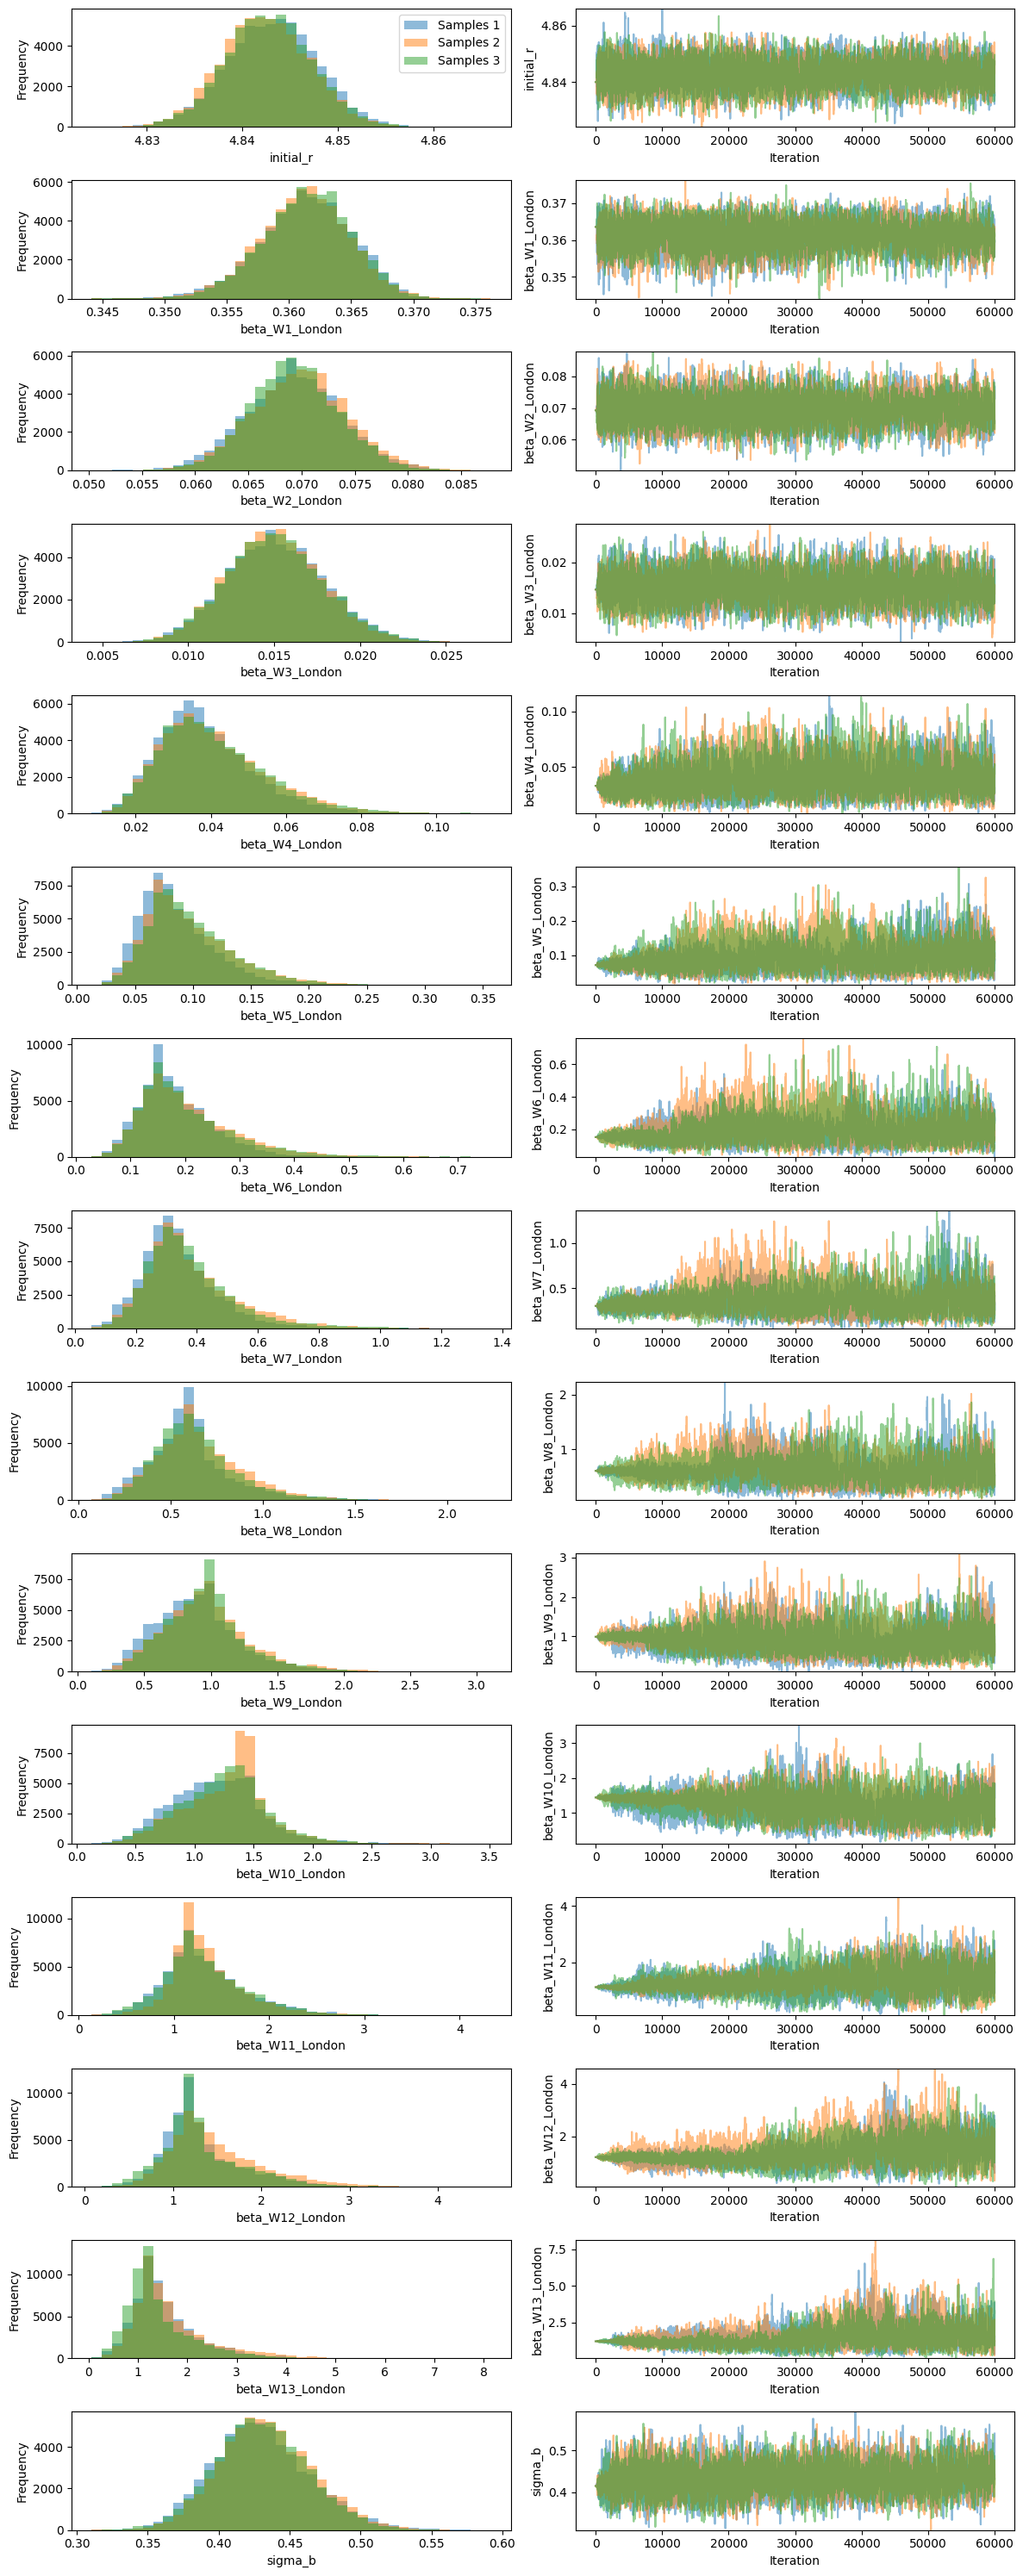

In [31]:
import pints.plot
 
# Plot histograms of the parameters inferred for London
param_names = ['initial_r']
param_names.extend(['beta_W{}_London'.format(i+1) for i in range(len(np.arange(44, len(times), 7)))])
param_names.extend(['sigma_b'])

pints.plot.trace(phe_samples, parameter_names=param_names)
plt.show()

In [32]:
# Eliminate burn-in iterations (1/2 of the chain lengths)
phe_samples = phe_samples[:, 30000:, :]

# Compute the R-hat estimates for the remaining samples
print(pints.rhat(phe_samples))

[1.00273755 1.00745851 1.00580442 1.00134984 1.01138217 1.03157062
 1.03845795 1.04259806 1.03792399 1.02818433 1.01522668 1.01446188
 1.03747589 1.01606034 1.00274819]


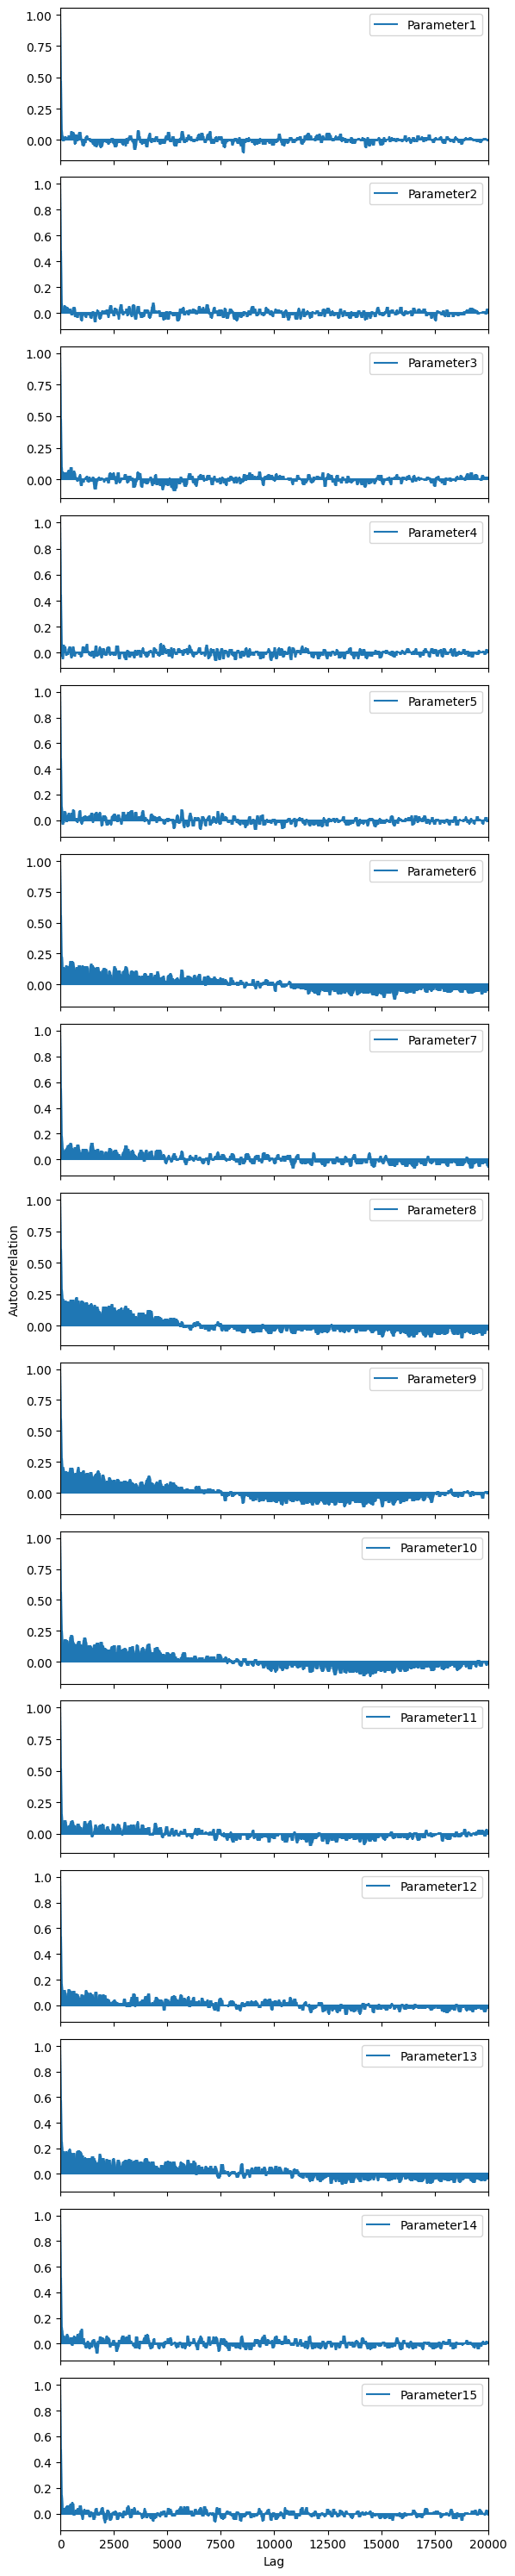

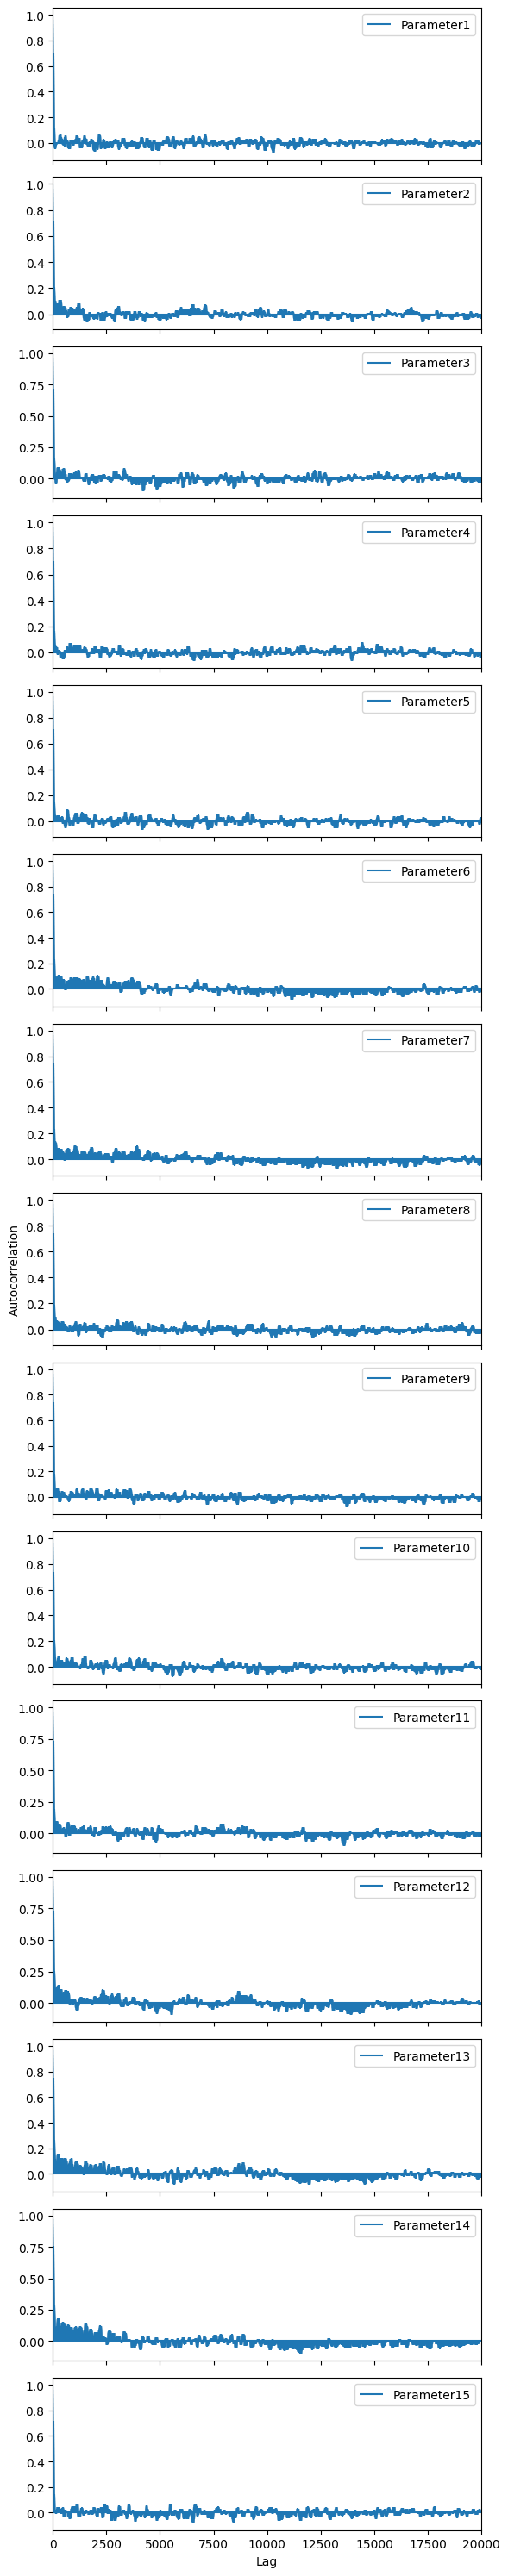

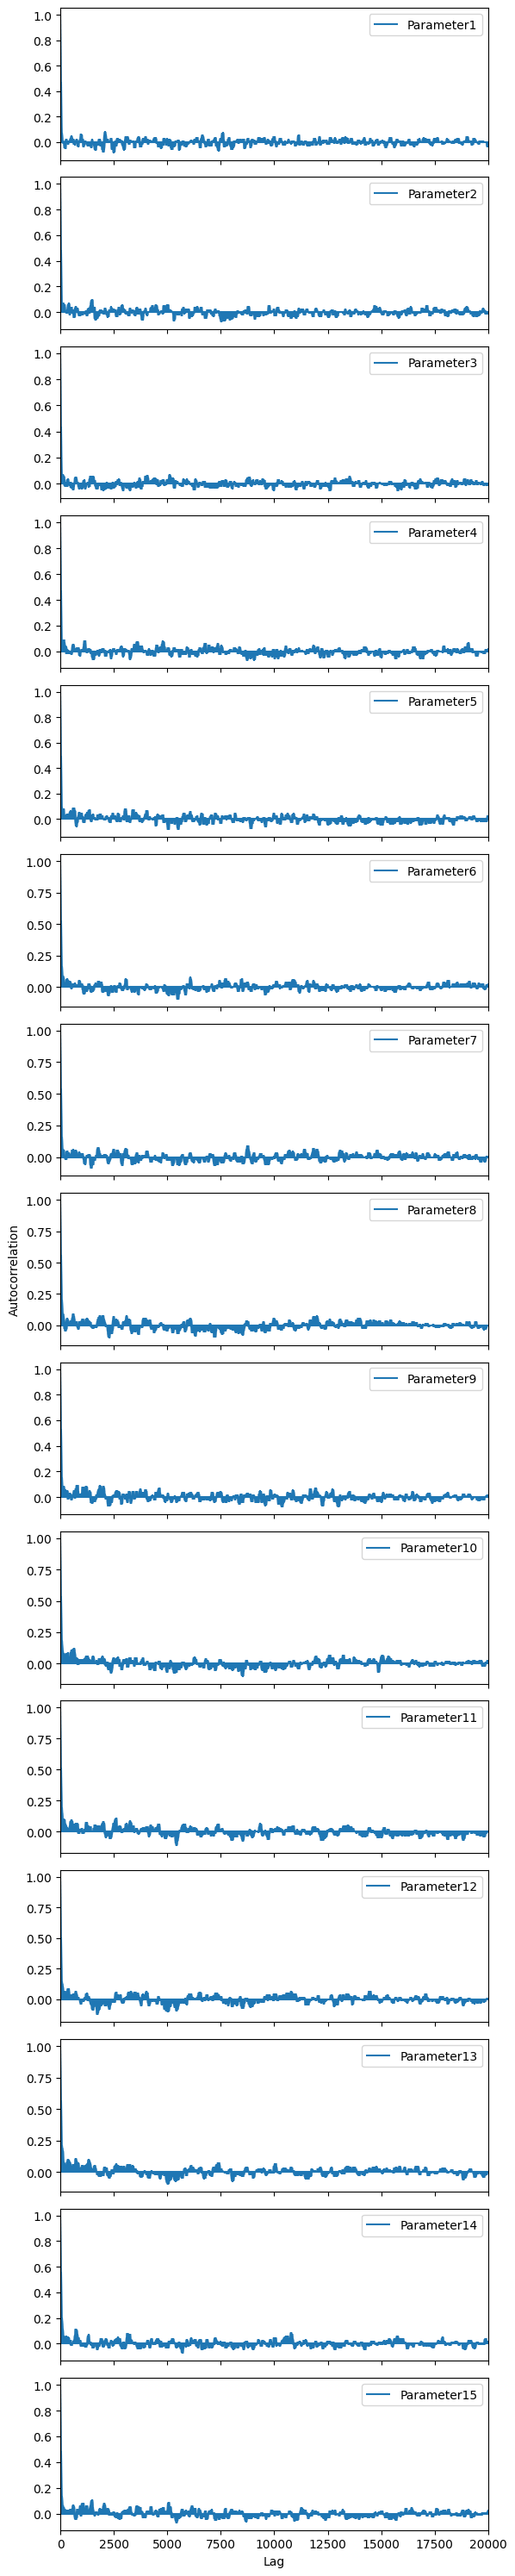

In [33]:
# Plot the autocorrelation for the three chains of parameters for South West
for phe_sample in phe_samples:
    pints.plot.autocorrelation(phe_sample, max_lags=20000)
    plt.show()

### Thin out the MCMC samples (by 10) and run the model with optimised parameter choices to produce predicted timelines for the:
 - number of new infections
 - number of deaths
 - R number

### Firstly save the samples

In [34]:
# Evaluate the model for all parameter sets in the samples
n_chains, n_sample, n_param = phe_samples.shape

phe_extended_samples = np.concatenate((phe_samples[0], phe_samples[1], phe_samples[2]), axis=0)

np.savetxt('inference_data/PHE_Samples.csv', phe_extended_samples, delimiter=',')

### PHE with fixed contacts

In [35]:
phe_extended_samples=np.loadtxt('inference_data/PHE_Samples.csv', delimiter=',')
total_samples = phe_extended_samples.shape[0]
thinning = max(1, int(total_samples / 9000))

phe_predicted_new_infec = []
phe_predicted_deaths = []
phe_predicted_reprod_num = []

# Run model and number of new infections for all regions
for r, _ in enumerate(regions):
    phe_reg_predicted_new_infec = []
    phe_reg_predicted_deaths = []
    phe_reg_predicted_reprod_num = []

    phe_model_parameters.regional_parameters.region_index = r+1

    for params in phe_extended_samples[::thinning, :]:
        phe_model_parameters.regional_parameters.initial_r = [params[0]] * len(phe_model.regions)
        
        phe_r = np.empty(len(times))
        phe_model_reg_deaths_data = np.empty(len(times))

        phe_m = em.MultiTimesInfectivity(
            matrices_contact, time_changes_contact, regions, matrices_region, time_changes_region,
            phe_model_parameters.regional_parameters.initial_r, phe_model_parameters.disease_parameters.dI,
            phe_model_parameters.ICs.susceptibles)

        # Run model and number of new infections for all age groups
        phe_model_output = phe_model.simulate(phe_model_parameters)

        phe_age_model_reg_new_infections = phe_model.new_infections(phe_model_output)
        phe_model_reg_new_infections = phe_age_model_reg_new_infections.sum(axis=1)

        for t, time in enumerate(times):
            phe_r[t] = phe_m.compute_reproduction_number(
                r+1, time, phe_model_output[t, :len(age_groups)],
                temp_variation=phe_model_parameters.regional_parameters.betas[r][t])
            phe_model_reg_deaths_data[t] = np.sum(phe_model.mean_deaths(
                fatality_ratio, time_to_death, t, phe_age_model_reg_new_infections))

        phe_reg_predicted_new_infec.append(phe_model_reg_new_infections)
        phe_reg_predicted_deaths.append(phe_model_reg_deaths_data)
        phe_reg_predicted_reprod_num.append(phe_r)

    phe_reg_predicted_new_infec = np.array(phe_reg_predicted_new_infec)

    phe_predicted_new_infec.append(phe_reg_predicted_new_infec)
    phe_predicted_deaths.append(phe_reg_predicted_deaths)
    phe_predicted_reprod_num.append(phe_reg_predicted_reprod_num)

phe_predicted_new_infec = np.array(phe_predicted_new_infec)
phe_predicted_deaths = np.array(phe_predicted_deaths)
phe_predicted_reprod_num = np.array(phe_predicted_reprod_num)

/Users/ioaros/Desktop/DPhil Project/multi-epi-model-cross-analysis/epimodels/phe_model.py:248: ComplexWarning:

Casting complex values to real discards the imaginary part

/var/folders/ph/jyxnc9y52svgq2k5lt2q4r000000gp/T/ipykernel_75203/3757061080.py:35: ComplexWarning:

Casting complex values to real discards the imaginary part



### Compute mean and CI bounds of the trajectories of interest and select predicted quantities to plot

### PHE with fixed contacts

In [36]:
# Set up traces to plot
phe_new_infec_mean = []
phe_deaths_mean = []
phe_reprod_num_mean = []

phe_new_infec_upper = []
phe_deaths_upper = []
phe_reprod_num_upper = []

phe_new_infec_lower = []
phe_deaths_lower = []
phe_reprod_num_lower = []

for r, _ in enumerate(regions):
    # Compute the mean 
    phe_new_infec_mean.append(np.mean(phe_predicted_new_infec[r,:,:], axis=0))
    phe_deaths_mean.append(np.mean(phe_predicted_deaths[r,:,:], axis=0))
    phe_reprod_num_mean.append(np.mean(phe_predicted_reprod_num[r,:,:], axis=0))

    # Compute the upper quantiles
    phe_new_infec_upper.append(np.quantile(phe_predicted_new_infec[r,:,:], 0.975, axis=0))
    phe_deaths_upper.append(np.quantile(phe_predicted_deaths[r,:,:], 0.975, axis=0))
    phe_reprod_num_upper.append(np.quantile(phe_predicted_reprod_num[r,:,:], 0.975, axis=0))

    # Compute the lower qunatiles
    phe_new_infec_lower.append(np.quantile(phe_predicted_new_infec[r,:,:], 0.025, axis=0))
    phe_deaths_lower.append(np.quantile(phe_predicted_deaths[r,:,:], 0.025, axis=0))
    phe_reprod_num_lower.append(np.quantile(phe_predicted_reprod_num[r,:,:], 0.025, axis=0))

In [37]:
# Trace names - represent the solver used for the simulation
trace_name = ['Synthetic']
titles = ['Infections', 'Deaths', 'Reproduction Number']

fig = go.Figure()
fig = make_subplots(rows=len(titles), cols=1, subplot_titles=tuple(titles), horizontal_spacing = 0.15)

# Plot (continuous predicted timeline and pointwise observed numbers each day)
for r, region in enumerate(regions):
    # Plot of infections
    fig.add_trace(
        go.Scatter(
            x=times,
            y=phe_new_infec_mean[r].tolist(),
            mode='lines',
            name=trace_name[r],
            line_color=colours[r]
        ),
        row= 1,
        col= 1
    )

    fig.add_trace(
        go.Scatter(
            x=times + times[::-1],
            y=phe_new_infec_upper[r].tolist() + phe_new_infec_lower[r].tolist()[::-1],
            fill='toself',
            fillcolor=colours[r],
            line_color=colours[r],
            opacity=0.3,
            mode='lines',
            showlegend=False,
            name=trace_name[r]
        ),
        row= 1,
        col= 1
    )

    fig.add_trace(
        go.Scatter(
            x=times,
            y=np.sum(cases_data[r], axis=1).tolist(),
            mode='markers',
            name=trace_name[r],
            showlegend=False,
            line_color=colours[r]
        ),
        row= 1,
        col= 1
    )

    # Plot deaths
    fig.add_trace(
        go.Scatter(
            x=times,
            y=phe_deaths_mean[r].tolist(),
            mode='lines',
            name=trace_name[r],
            showlegend=False,
            line_color=colours[r]
        ),
        row= 2,
        col= 1
    )

    fig.add_trace(
        go.Scatter(
            x=times + times[::-1],
            y=phe_deaths_upper[r].tolist() + phe_deaths_lower[r].tolist()[::-1],
            fill='toself',
            fillcolor=colours[r],
            line_color=colours[r],
            opacity=0.3,
            mode='lines',
            showlegend=False,
            name=trace_name[r]
        ),
        row= 2,
        col= 1
    )

    fig.add_trace(
        go.Scatter(
            x=times,
            y=np.sum(deaths_data[r], axis=1).tolist(),
            mode='markers',
            name=trace_name[r],
            showlegend=False,
            line_color=colours[r]
        ),
        row= 2,
        col= 1
    )

    # Plot reproduction number
    fig.add_trace(
        go.Scatter(
            x=times,
            y=phe_reprod_num_mean[r].tolist(),
            mode='lines',
            name=trace_name[r],
            showlegend=False,
            line_color=colours[r]
        ),
        row= 3,
        col= 1
    )

    fig.add_trace(
        go.Scatter(
            x=times + times[::-1],
            y=phe_reprod_num_upper[r].tolist() + phe_reprod_num_lower[r].tolist()[::-1],
            fill='toself',
            fillcolor=colours[r],
            line_color=colours[r],
            opacity=0.3,
            mode='lines',
            showlegend=False,
            name=trace_name[r]
        ),
        row= 3,
        col= 1
    )

# Add axis labels
fig.update_layout(
    width=600, 
    height=900,
    plot_bgcolor='white',
    xaxis=dict(
        linecolor='black',
        tickvals=np.arange(1, 90, 10).tolist(),
        ticktext=['Feb 15', 'Feb 25', 'Mar 06', 'Mar 16', 'Mar 26', 'Apr 05', 'Apr 15', 'Apr 25', 'May 05', 'May 15']),
    yaxis=dict(linecolor='black'),
    xaxis2=dict(
        linecolor='black',
        tickvals=np.arange(1, 90, 10).tolist(),
        ticktext=['Feb 15', 'Feb 25', 'Mar 06', 'Mar 16', 'Mar 26', 'Apr 05', 'Apr 15', 'Apr 25', 'May 05', 'May 15']),
    yaxis2=dict(linecolor='black'),
    xaxis3=dict(
        linecolor='black',
        tickvals=np.arange(1, 90, 10).tolist(),
        ticktext=['Feb 15', 'Feb 25', 'Mar 06', 'Mar 16', 'Mar 26', 'Apr 05', 'Apr 15', 'Apr 25', 'May 05', 'May 15']),
    yaxis3=dict(linecolor='black'),
    legend=dict(
        orientation='h',
        yanchor="bottom",
        y=1.075,
        xanchor="right",
        x=1)
    )

fig.write_image('images/Figure-PHE-Luxembourg.pdf')
fig.show()

### Roche (without NPIs)

In [38]:
# Set random seed
np.random.seed(27)

In [39]:
# Initialise inference for the model
roche_inference = em.inference.RocheSEIRInfer(roche_model)

# Add model, death, tests and NPIs data to the inference structure
roche_inference.read_model_data([susceptibles], [infectives])
roche_inference.read_deaths_data(deaths_data_tofit, deaths_times)
roche_inference.read_serology_data(tests, positives_data_tofit, serology_times, sens, spec)
roche_inference.read_npis_data(max_levels_npi, targeted_npi, general_npi, reg_levels_npi, time_changes_npi, time_changes_flag)

# Run inference structure
found, log_likelihood = roche_inference.optimisation_problem_setup(times, wd=1, wp=0)
roche_samples = roche_inference.inference_problem_setup(times, num_iter=60000, wd=1, wp=0)

Maximising LogPDF
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in sequential mode.
Population size: 6
Iter. Eval. Best      Current   Time    
0     6     -34832.17 -34832.17   0:00.4
1     12    -33746.43 -33746.43   0:00.7
2     18    -32016.83 -32016.83   0:01.0
3     24    -31270.33 -31270.33   0:01.2
20    126   -7964.168 -8064.808   0:06.0
40    246   -7722.346 -7722.346   0:12.0
60    366   -7721.54  -7721.965   0:18.5
80    486   -7721.524 -7721.529   0:24.1
100   606   -7721.524 -7721.524   0:30.3
120   726   -7721.524 -7721.524   0:35.9


/Users/ioaros/opt/anaconda3/envs/epimodels/lib/python3.12/site-packages/cma/evolution_strategy.py:3823: RuntimeWarning:

invalid value encountered in scalar subtract



140   846   -7721.524 -7721.524   0:41.9
141   846   -7721.524 -7721.524   0:41.9
Halting: No significant change for 100 iterations.
[ 0.66370531 10.        ] -7721.523813582507
Optimisation phase is finished.
Maximising LogPDF
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in sequential mode.
Population size: 6
Iter. Eval. Best      Current   Time    
0     6     -34978.91 -34978.91   0:00.4
1     12    -34978.91 -35057.96   0:00.7
2     18    -34694.93 -34694.93   0:01.1
3     24    -34282.29 -34282.29   0:01.4
20    126   -17158.51 -17158.51   0:07.6
40    246   -7802.754 -8032.316   0:13.1
60    366   -7723.995 -7728.561   0:19.7
80    486   -7721.563 -7721.585   0:25.9
100   606   -7721.524 -7721.53    0:31.2
120   726   -7721.524 -7721.524   0:36.8
140   846   -7721.524 -7721.524   0:43.2
160   966   -7721.524 -7721.524   0:50.0
165   990   -7721.524 -7721.524   0:51.6
Halting: No significant change for 100 iterations.
[ 0.71450209 10.        ] -7721.52381

In [43]:
n_parameters = roche_model.n_parameters()

predicted_new_infec = []
predicted_deaths = []
predicted_reprod_num = []

# Run model and number of new infections for all regions
for r, _ in enumerate(phe_model.regions):
    roche_model_parameters.simulation_parameters.region_index = r+1
    
    roche_model_parameters.transmission_parameters.beta_min = found[0]
    roche_model_parameters.transmission_parameters.bss = found[1]
    
    roche_r = np.empty(len(times))
    roche_model_reg_deaths_data = np.empty(len(times))

    # Run model and number of new infections for all age groups
    roche_model_output = roche_model.simulate(roche_model_parameters)
    
    roche_age_model_reg_new_infections = roche_model.new_infections(roche_model_output)
    roche_model_reg_new_infections = roche_age_model_reg_new_infections.sum(axis=1)

    roche_age_model_reg_new_deaths = roche_model.new_deaths(roche_model_output)
    
    roche_model.compute_transition_matrix()
    for t, time in enumerate(times):
        roche_r[t] = roche_model.compute_rt_trajectory(roche_model_output, t)
        roche_model_reg_deaths_data[t] = np.sum(roche_model.mean_deaths(
            t, roche_age_model_reg_new_deaths))

    predicted_new_infec.append(roche_model_reg_new_infections)
    predicted_deaths.append(roche_model_reg_deaths_data)
    predicted_reprod_num.append(roche_r)

predicted_new_infec = np.array(predicted_new_infec)
predicted_deaths = np.array(predicted_deaths)
predicted_reprod_num = np.array(predicted_reprod_num)

In [44]:
# Set up traces to plot
new_infec_pred = []
deaths_pred = []
reprod_num_pred = []

for r, _ in enumerate(phe_model.regions):
    # Compute the prediction 
    new_infec_pred.append(predicted_new_infec[r,:])
    deaths_pred.append(predicted_deaths[r,:])
    reprod_num_pred.append(predicted_reprod_num[r,:])

In [45]:
# Trace names - represent the solver used for the simulation
trace_name = regions
titles = ['Infections', 'Deaths', 'Reproduction Number']

fig = go.Figure()
fig = make_subplots(rows=len(titles), cols=1, subplot_titles=tuple(titles), horizontal_spacing = 0.15)

# Plot (continuous predicted timeline and pointwise observed numbers each day)
for r, region in enumerate(regions):
    # Plot of infections
    fig.add_trace(
        go.Scatter(
            x=times,
            y=new_infec_pred[r].tolist(),
            mode='lines',
            name=trace_name[r],
            line_color=colours[r]
        ),
        row= 1,
        col= 1
    )

    fig.add_trace(
        go.Scatter(
            x=times,
            y=np.sum(cases_data[r], axis=1).tolist(),
            mode='markers',
            name=trace_name[r],
            showlegend=False,
            line_color=colours[r]
        ),
        row= 1,
        col= 1
    )

    # Plot deaths
    fig.add_trace(
        go.Scatter(
            x=times,
            y=deaths_pred[r].tolist(),
            mode='lines',
            name=trace_name[r],
            showlegend=False,
            line_color=colours[r]
        ),
        row= 2,
        col= 1
    )

    fig.add_trace(
        go.Scatter(
            x=deaths_times,
            y=np.sum(deaths_data[r], axis=1).tolist(),
            mode='markers',
            name=trace_name[r],
            showlegend=False,
            line_color=colours[r]
        ),
        row= 2,
        col= 1
    )

    # Plot reproduction number
    fig.add_trace(
        go.Scatter(
            x=times,
            y=reprod_num_pred[r].tolist(),
            mode='lines',
            name=trace_name[r],
            showlegend=False,
            line_color=colours[r]
        ),
        row= 3,
        col= 1
    )

# Add axis labels
fig.update_layout(
    width=600, 
    height=900,
    plot_bgcolor='white',
    xaxis=dict(
        linecolor='black',
        tickvals=np.arange(1, total_days, 10).tolist(),
        ticktext=['Feb 15', 'Feb 25', 'Mar 06', 'Mar 16', 'Mar 26', 'Apr 05', 'Apr 15', 'Apr 25', 'May 05', 'May 15', 'May 25', 'Jun 04', 'Jun 14', 'Jun 24']),
    yaxis=dict(linecolor='black'),
    xaxis2=dict(
        linecolor='black',
        tickvals=np.arange(1, total_days, 10).tolist(),
        ticktext=['Feb 15', 'Feb 25', 'Mar 06', 'Mar 16', 'Mar 26', 'Apr 05', 'Apr 15', 'Apr 25', 'May 05', 'May 15', 'May 25', 'Jun 04', 'Jun 14', 'Jun 24']),
    yaxis2=dict(linecolor='black'),
    xaxis3=dict(
        linecolor='black',
        tickvals=np.arange(1, total_days, 10).tolist(),
        ticktext=['Feb 15', 'Feb 25', 'Mar 06', 'Mar 16', 'Mar 26', 'Apr 05', 'Apr 15', 'Apr 25', 'May 05', 'May 15', 'May 25', 'Jun 04', 'Jun 14', 'Jun 24']),
    yaxis3=dict(linecolor='black'),
    legend=dict(
        orientation='h',
        yanchor="bottom",
        y=1.075,
        xanchor="right",
        x=1)
    )

fig.write_image('images/Figure-Roche-optimisation.pdf')
fig.show()

### Quality check of the inference procedure

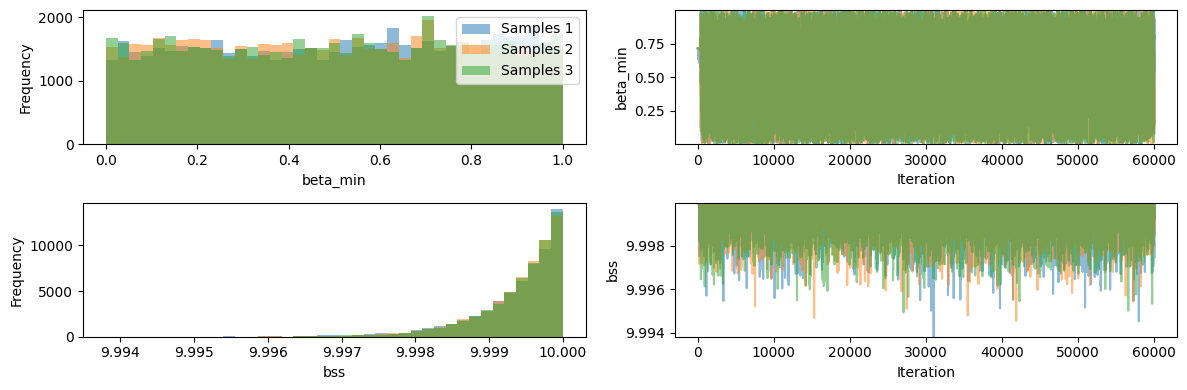

In [40]:
import pints.plot

# Plot histograms of the parameters inferred for South West
# param_names = ['Initial Pss']
# for age in model.age_groups:
#     param_names.append('kR_{}'.format(age))

# for age in model.age_groups:
#     param_names.append('Pa_{}'.format(age))
param_names=['beta_min', 'bss']

pints.plot.trace(roche_samples, parameter_names=param_names)
plt.show()

In [41]:
# Eliminate burn-in iterations (1/2 of the chain lengths)
roche_samples = roche_samples[:, 30000:, :]

# Compute the R-hat estimates for the remaining samples
print(pints.rhat(roche_samples))

[1.0011658  1.00168661]


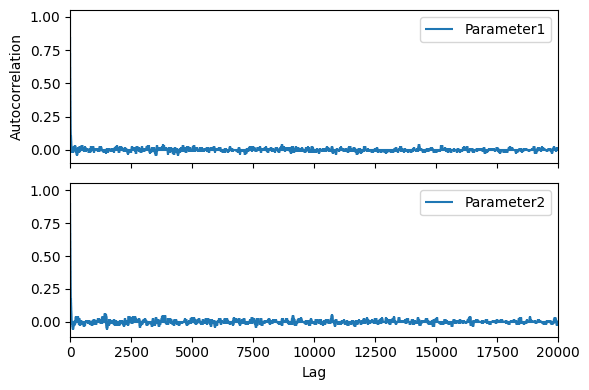

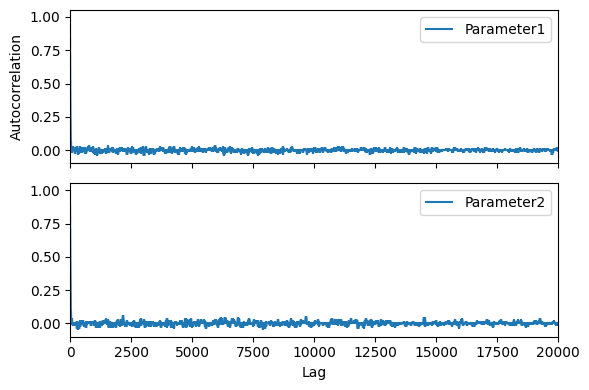

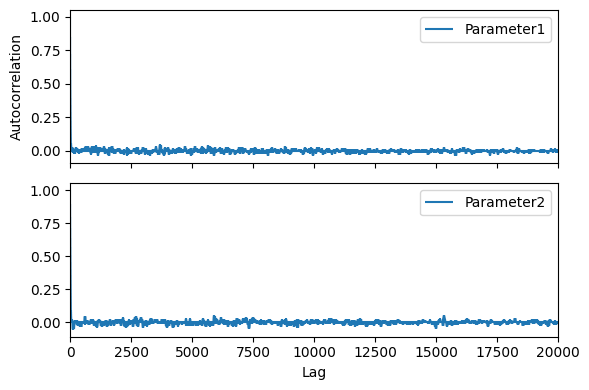

In [42]:
# Plot the autocorrelation for the three chains of parameters for South West
for roche_sample in roche_samples:
    pints.plot.autocorrelation(roche_sample, max_lags=20000)
    plt.show()

### Thin out the MCMC samples (by 10) and run the model with optimised parameter choices to produce predicted timelines for the:
 - number of new infections
 - number of deaths
 - R number

### Firstly save samples

In [46]:
# Evaluate the model for all parameter sets in the samples
n_chains, n_sample, n_param = roche_samples.shape

roche_extended_samples = np.concatenate((roche_samples[0], roche_samples[1], roche_samples[2]), axis=0)

np.savetxt('inference_data/Roche_Samples.csv', roche_extended_samples, delimiter=',')

### Roche with no NPIs

In [47]:
roche_extended_samples=np.loadtxt('inference_data/Roche_Samples.csv', delimiter=',')
total_samples = roche_extended_samples.shape[0]
thinning = max(1, int(total_samples / 9000))

roche_predicted_new_infec = []
roche_predicted_deaths = []
roche_predicted_reprod_num = []

# Run model and number of new infections for all regions
for r, _ in enumerate(regions):
    roche_reg_predicted_new_infec = []
    roche_reg_predicted_deaths = []
    roche_reg_predicted_reprod_num = []

    roche_model_parameters.simulation_parameters.region_index = r+1

    for params in roche_extended_samples[::thinning, :]:
        roche_model_parameters.transmission_parameters.beta_min = params[0]
        roche_model_parameters.transmission_parameters.bss = params[1]
        
        roche_r = np.empty(len(times))
        roche_model_reg_deaths_data = np.empty(len(times))

        # Run model and number of new infections for all age groups
        roche_model_output = roche_model.simulate(roche_model_parameters)
        
        roche_age_model_reg_new_infections = roche_model.new_infections(roche_model_output)
        roche_model_reg_new_infections = roche_age_model_reg_new_infections.sum(axis=1)

        roche_age_model_reg_new_deaths = roche_model.new_deaths(roche_model_output)
        
        roche_model.compute_transition_matrix()
        for t, time in enumerate(times):
            roche_r[t] = roche_model.compute_rt_trajectory(roche_model_output, t)
            roche_model_reg_deaths_data[t] = np.sum(roche_model.mean_deaths(
                t, roche_age_model_reg_new_deaths))

        roche_reg_predicted_new_infec.append(roche_model_reg_new_infections)
        roche_reg_predicted_deaths.append(roche_model_reg_deaths_data)
        roche_reg_predicted_reprod_num.append(roche_r)

    roche_reg_predicted_new_infec = np.array(roche_reg_predicted_new_infec)
 
    roche_predicted_new_infec.append(roche_reg_predicted_new_infec)
    roche_predicted_deaths.append(roche_reg_predicted_deaths)
    roche_predicted_reprod_num.append(roche_reg_predicted_reprod_num)

roche_predicted_new_infec = np.array(roche_predicted_new_infec)
roche_predicted_deaths = np.array(roche_predicted_deaths)
roche_predicted_reprod_num = np.array(roche_predicted_reprod_num)


### Compute mean and CI bounds of the trajectories of interest and select predicted quantities to plot

### Roche with no NPIs

In [48]:
# Set up traces to plot
roche_new_infec_mean = []
roche_deaths_mean = []
roche_reprod_num_mean = []

roche_new_infec_upper = []
roche_deaths_upper = []
roche_reprod_num_upper = []

roche_new_infec_lower = []
roche_deaths_lower = []
roche_reprod_num_lower = []

for r, _ in enumerate(regions):
    # Compute the mean 
    roche_new_infec_mean.append(np.mean(roche_predicted_new_infec[r,:,:], axis=0))
    roche_deaths_mean.append(np.mean(roche_predicted_deaths[r,:,:], axis=0))
    roche_reprod_num_mean.append(np.mean(roche_predicted_reprod_num[r,:,:], axis=0))

    # Compute the upper quantiles
    roche_new_infec_upper.append(np.quantile(roche_predicted_new_infec[r,:,:], 0.975, axis=0))
    roche_deaths_upper.append(np.quantile(roche_predicted_deaths[r,:,:], 0.975, axis=0))
    roche_reprod_num_upper.append(np.quantile(roche_predicted_reprod_num[r,:,:], 0.975, axis=0))

    # Compute the lower qunatiles
    roche_new_infec_lower.append(np.quantile(roche_predicted_new_infec[r,:,:], 0.025, axis=0))
    roche_deaths_lower.append(np.quantile(roche_predicted_deaths[r,:,:], 0.025, axis=0))
    roche_reprod_num_lower.append(np.quantile(roche_predicted_reprod_num[r,:,:], 0.025, axis=0))

In [50]:
# Trace names - represent the solver used for the simulation
trace_name = ['Synthetic']
titles = ['Infections', 'Deaths', 'Reproduction Number']

fig = go.Figure()
fig = make_subplots(rows=len(titles), cols=1, subplot_titles=tuple(titles), horizontal_spacing = 0.15)

# Plot (continuous predicted timeline and pointwise observed numbers each day)
for r, region in enumerate(regions):
    # Plot of infections
    fig.add_trace(
        go.Scatter(
            x=times,
            y=roche_new_infec_mean[r].tolist(),
            mode='lines',
            name=trace_name[r],
            line_color=colours[r]
        ),
        row= 1,
        col= 1
    )

    fig.add_trace(
        go.Scatter(
            x=times + times[::-1],
            y=roche_new_infec_upper[r].tolist() + roche_new_infec_lower[r].tolist()[::-1],
            fill='toself',
            fillcolor=colours[r],
            line_color=colours[r],
            opacity=0.3,
            mode='lines',
            showlegend=False,
            name=trace_name[r]
        ),
        row= 1,
        col= 1
    )

    fig.add_trace(
        go.Scatter(
            x=times,
            y=np.sum(cases_data[r], axis=1).tolist(),
            mode='markers',
            name=trace_name[r],
            showlegend=False,
            line_color=colours[r]
        ),
        row= 1,
        col= 1
    )

    # Plot deaths
    fig.add_trace(
        go.Scatter(
            x=times,
            y=roche_deaths_mean[r].tolist(),
            mode='lines',
            name=trace_name[r],
            showlegend=False,
            line_color=colours[r]
        ),
        row= 2,
        col= 1
    )

    fig.add_trace(
        go.Scatter(
            x=times + times[::-1],
            y=roche_deaths_upper[r].tolist() + roche_deaths_lower[r].tolist()[::-1],
            fill='toself',
            fillcolor=colours[r],
            line_color=colours[r],
            opacity=0.3,
            mode='lines',
            showlegend=False,
            name=trace_name[r]
        ),
        row= 2,
        col= 1
    )

    fig.add_trace(
        go.Scatter(
            x=times,
            y=np.sum(deaths_data[r], axis=1).tolist(),
            mode='markers',
            name=trace_name[r],
            showlegend=False,
            line_color=colours[r]
        ),
        row= 2,
        col= 1
    )

    # Plot reproduction number
    fig.add_trace(
        go.Scatter(
            x=times,
            y=roche_reprod_num_mean[r].tolist(),
            mode='lines',
            name=trace_name[r],
            showlegend=False,
            line_color=colours[r]
        ),
        row= 3,
        col= 1
    )

    fig.add_trace(
        go.Scatter(
            x=times + times[::-1],
            y=roche_reprod_num_upper[r].tolist() + roche_reprod_num_lower[r].tolist()[::-1],
            fill='toself',
            fillcolor=colours[r],
            line_color=colours[r],
            opacity=0.3,
            mode='lines',
            showlegend=False,
            name=trace_name[r]
        ),
        row= 3,
        col= 1
    )

# Add axis labels
fig.update_layout(
    width=600, 
    height=900,
    plot_bgcolor='white',
    xaxis=dict(
        linecolor='black',
        tickvals=np.arange(1, 90, 10).tolist(),
        ticktext=['Feb 15', 'Feb 25', 'Mar 06', 'Mar 16', 'Mar 26', 'Apr 05', 'Apr 15', 'Apr 25', 'May 05', 'May 15']),
    yaxis=dict(linecolor='black'),
    xaxis2=dict(
        linecolor='black',
        tickvals=np.arange(1, 90, 10).tolist(),
        ticktext=['Feb 15', 'Feb 25', 'Mar 06', 'Mar 16', 'Mar 26', 'Apr 05', 'Apr 15', 'Apr 25', 'May 05', 'May 15']),
    yaxis2=dict(linecolor='black'),
    xaxis3=dict(
        linecolor='black',
        tickvals=np.arange(1, 90, 10).tolist(),
        ticktext=['Feb 15', 'Feb 25', 'Mar 06', 'Mar 16', 'Mar 26', 'Apr 05', 'Apr 15', 'Apr 25', 'May 05', 'May 15']),
    yaxis3=dict(linecolor='black'),
    legend=dict(
        orientation='h',
        yanchor="bottom",
        y=1.075,
        xanchor="right",
        x=1)
    )

fig.write_image('images/Figure-Roche-Luxembourg.pdf')
fig.show()

### Roche with changed parameters (without NPIs)

In [52]:
# Set random seed
np.random.seed(27)

In [54]:
# Initialise inference for the model
roche_mod_inference = em.inference.RocheSEIRInfer(roche_model_mod)

# Add model, death, tests and NPIs data to the inference structure
roche_mod_inference.read_model_data([susceptibles], [infectives])
roche_mod_inference.read_deaths_data(deaths_data_tofit, deaths_times)
roche_mod_inference.read_serology_data(tests, positives_data_tofit, serology_times, sens, spec)
roche_mod_inference.read_npis_data(max_levels_npi, targeted_npi, general_npi, reg_levels_npi, time_changes_npi, time_changes_flag)

# Run inference structure
found, log_likelihood = roche_mod_inference.optimisation_problem_setup(times, wd=1, wp=0)
roche_mod_samples = roche_mod_inference.inference_problem_setup(times, num_iter=60000, wd=1, wp=0)

Maximising LogPDF
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in sequential mode.
Population size: 6
Iter. Eval. Best      Current   Time    
0     6     -5823.17  -5823.17    0:00.3
1     12    -5384.382 -5384.382   0:00.7
2     18    -5384.382 -5656.778   0:01.2
3     24    -4737.546 -4737.546   0:01.5
20    126   -1956.568 -1956.576   0:08.0
40    246   -1956.568 -1956.568   0:15.3
60    366   -1956.568 -1956.568   0:22.6
80    486   -1956.568 -1956.568   0:30.1
100   606   -1956.568 -1956.568   0:37.5
112   672   -1956.568 -1956.568   0:41.6
Halting: No significant change for 100 iterations.
[0.18975083 5.79576   ] -1956.5683711505362
Optimisation phase is finished.
Maximising LogPDF
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in sequential mode.
Population size: 6
Iter. Eval. Best      Current   Time    
0     6     -6070.411 -6070.411   0:00.3
1     12    -6070.411 -6161.13    0:00.7
2     18    -5651.314 -5651.314   0:01.0
3 

In [55]:
n_parameters = roche_model_mod.n_parameters()

predicted_new_infec = []
predicted_deaths = []
predicted_reprod_num = []

# Run model and number of new infections for all regions
for r, _ in enumerate(phe_model.regions):
    roche_model_mod_parameters.simulation_parameters.region_index = r+1
    
    roche_model_mod_parameters.transmission_parameters.beta_min = found[0]
    roche_model_mod_parameters.transmission_parameters.bss = found[1]
    
    roche_r = np.empty(len(times))
    roche_model_mod_reg_deaths_data = np.empty(len(times))

    # Run model and number of new infections for all age groups
    roche_model_mod_output = roche_model_mod.simulate(roche_model_mod_parameters)
    
    roche_age_model_mod_reg_new_infections = roche_model_mod.new_infections(roche_model_mod_output)
    roche_model_mod_reg_new_infections = roche_age_model_mod_reg_new_infections.sum(axis=1)

    roche_age_model_mod_reg_new_deaths = roche_model_mod.new_deaths(roche_model_mod_output)
    
    roche_model_mod.compute_transition_matrix()
    for t, time in enumerate(times):
        roche_r[t] = roche_model.compute_rt_trajectory(roche_model_mod_output, t)
        roche_model_mod_reg_deaths_data[t] = np.sum(roche_model_mod.mean_deaths(
            t, roche_age_model_mod_reg_new_deaths))

    predicted_new_infec.append(roche_model_mod_reg_new_infections)
    predicted_deaths.append(roche_model_mod_reg_deaths_data)
    predicted_reprod_num.append(roche_r)

predicted_new_infec = np.array(predicted_new_infec)
predicted_deaths = np.array(predicted_deaths)
predicted_reprod_num = np.array(predicted_reprod_num)

In [56]:
# Set up traces to plot
new_infec_pred = []
deaths_pred = []
reprod_num_pred = []

for r, _ in enumerate(phe_model.regions):
    # Compute the prediction 
    new_infec_pred.append(predicted_new_infec[r,:])
    deaths_pred.append(predicted_deaths[r,:])
    reprod_num_pred.append(predicted_reprod_num[r,:])

In [57]:
# Trace names - represent the solver used for the simulation
trace_name = regions
titles = ['Infections', 'Deaths', 'Reproduction Number']

fig = go.Figure()
fig = make_subplots(rows=len(titles), cols=1, subplot_titles=tuple(titles), horizontal_spacing = 0.15)

# Plot (continuous predicted timeline and pointwise observed numbers each day)
for r, region in enumerate(regions):
    # Plot of infections
    fig.add_trace(
        go.Scatter(
            x=times,
            y=new_infec_pred[r].tolist(),
            mode='lines',
            name=trace_name[r],
            line_color=colours[r]
        ),
        row= 1,
        col= 1
    )

    fig.add_trace(
        go.Scatter(
            x=times,
            y=np.sum(cases_data[r], axis=1).tolist(),
            mode='markers',
            name=trace_name[r],
            showlegend=False,
            line_color=colours[r]
        ),
        row= 1,
        col= 1
    )

    # Plot deaths
    fig.add_trace(
        go.Scatter(
            x=times,
            y=deaths_pred[r].tolist(),
            mode='lines',
            name=trace_name[r],
            showlegend=False,
            line_color=colours[r]
        ),
        row= 2,
        col= 1
    )

    fig.add_trace(
        go.Scatter(
            x=deaths_times,
            y=np.sum(deaths_data[r], axis=1).tolist(),
            mode='markers',
            name=trace_name[r],
            showlegend=False,
            line_color=colours[r]
        ),
        row= 2,
        col= 1
    )

    # Plot reproduction number
    fig.add_trace(
        go.Scatter(
            x=times,
            y=reprod_num_pred[r].tolist(),
            mode='lines',
            name=trace_name[r],
            showlegend=False,
            line_color=colours[r]
        ),
        row= 3,
        col= 1
    )

# Add axis labels
fig.update_layout(
    width=600, 
    height=900,
    plot_bgcolor='white',
    xaxis=dict(
        linecolor='black',
        tickvals=np.arange(1, total_days, 10).tolist(),
        ticktext=['Feb 15', 'Feb 25', 'Mar 06', 'Mar 16', 'Mar 26', 'Apr 05', 'Apr 15', 'Apr 25', 'May 05', 'May 15', 'May 25', 'Jun 04', 'Jun 14', 'Jun 24']),
    yaxis=dict(linecolor='black'),
    xaxis2=dict(
        linecolor='black',
        tickvals=np.arange(1, total_days, 10).tolist(),
        ticktext=['Feb 15', 'Feb 25', 'Mar 06', 'Mar 16', 'Mar 26', 'Apr 05', 'Apr 15', 'Apr 25', 'May 05', 'May 15', 'May 25', 'Jun 04', 'Jun 14', 'Jun 24']),
    yaxis2=dict(linecolor='black'),
    xaxis3=dict(
        linecolor='black',
        tickvals=np.arange(1, total_days, 10).tolist(),
        ticktext=['Feb 15', 'Feb 25', 'Mar 06', 'Mar 16', 'Mar 26', 'Apr 05', 'Apr 15', 'Apr 25', 'May 05', 'May 15', 'May 25', 'Jun 04', 'Jun 14', 'Jun 24']),
    yaxis3=dict(linecolor='black'),
    legend=dict(
        orientation='h',
        yanchor="bottom",
        y=1.075,
        xanchor="right",
        x=1)
    )

fig.write_image('images/Figure-Roche-mod-optimisation.pdf')
fig.show()

### Quality check of the inference procedure

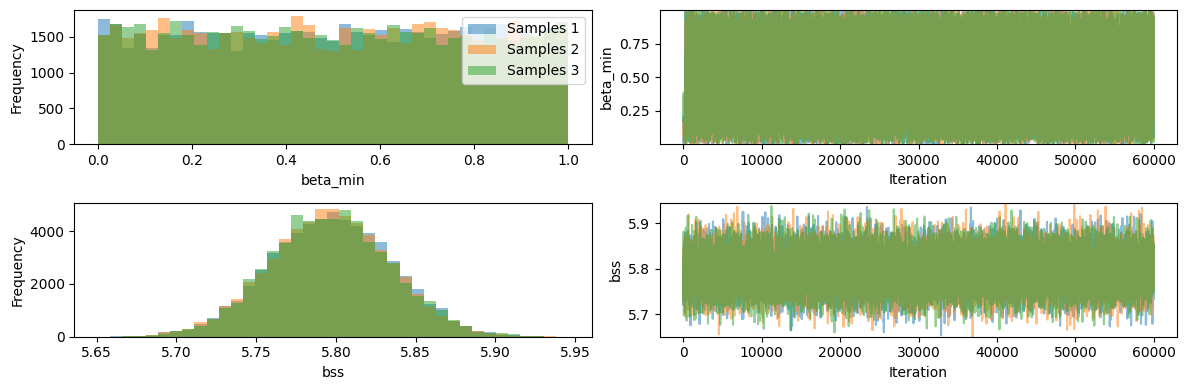

In [58]:
import pints.plot

# Plot histograms of the parameters inferred for South West
# param_names = ['Initial Pss']
# for age in model.age_groups:
#     param_names.append('kR_{}'.format(age))

# for age in model.age_groups:
#     param_names.append('Pa_{}'.format(age))
param_names=['beta_min', 'bss']

pints.plot.trace(roche_mod_samples, parameter_names=param_names)
plt.show()

In [59]:
# Eliminate burn-in iterations (1/2 of the chain lengths)
roche_mod_samples = roche_mod_samples[:, 30000:, :]

# Compute the R-hat estimates for the remaining samples
print(pints.rhat(roche_mod_samples))

[1.00027731 1.0008697 ]


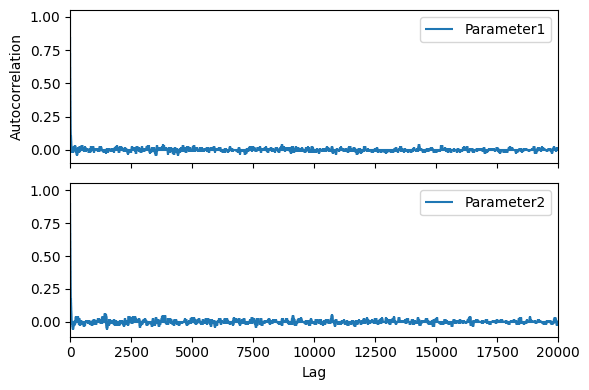

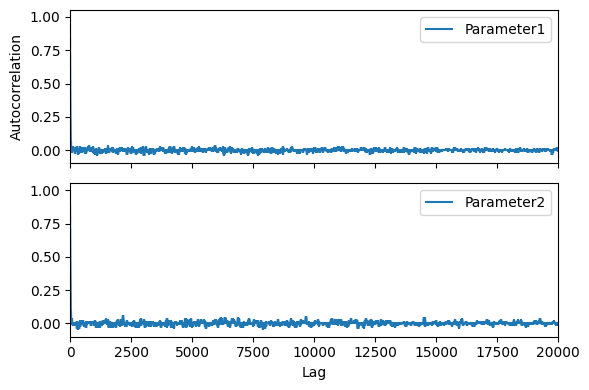

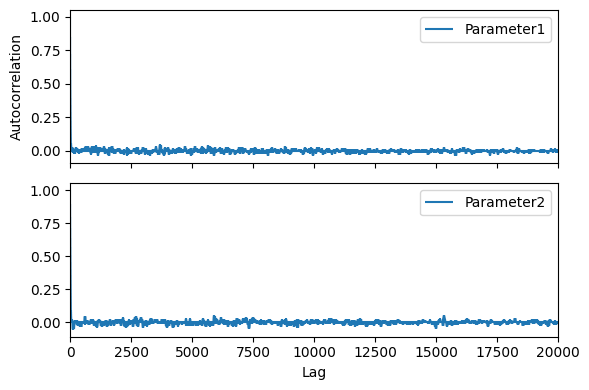

In [60]:
# Plot the autocorrelation for the three chains of parameters for South West
for roche_mod_sample in roche_samples:
    pints.plot.autocorrelation(roche_mod_sample, max_lags=20000)
    plt.show()

### Thin out the MCMC samples (by 10) and run the model with optimised parameter choices to produce predicted timelines for the:
 - number of new infections
 - number of deaths
 - R number

### Firstly save samples

In [61]:
# Evaluate the model for all parameter sets in the samples
n_chains, n_sample, n_param = roche_mod_samples.shape

roche_mod_extended_samples = np.concatenate((roche_mod_samples[0], roche_mod_samples[1], roche_mod_samples[2]), axis=0)

np.savetxt('inference_data/Roche_Mod_Samples.csv', roche_mod_extended_samples, delimiter=',')

### Roche with no NPIs

In [62]:
roche_mod_extended_samples=np.loadtxt('inference_data/Roche_Mod_Samples.csv', delimiter=',')
total_samples = roche_mod_extended_samples.shape[0]
thinning = max(1, int(total_samples / 9000))

roche_mod_predicted_new_infec = []
roche_mod_predicted_deaths = []
roche_mod_predicted_reprod_num = []

# Run model and number of new infections for all regions
for r, _ in enumerate(regions):
    roche_mod_reg_predicted_new_infec = []
    roche_mod_reg_predicted_deaths = []
    roche_mod_reg_predicted_reprod_num = []

    roche_model_mod_parameters.simulation_parameters.region_index = r+1

    for params in roche_mod_extended_samples[::thinning, :]:
        roche_model_mod_parameters.transmission_parameters.beta_min = params[0]
        roche_model_mod_parameters.transmission_parameters.bss = params[1]
        
        roche_r_mod = np.empty(len(times))
        roche_model_mod_reg_deaths_data = np.empty(len(times))

        # Run model and number of new infections for all age groups
        roche_model_mod_output = roche_model_mod.simulate(roche_model_mod_parameters)
        
        roche_age_model_mod_reg_new_infections = roche_model.new_infections(roche_model_mod_output)
        roche_model_mod_reg_new_infections = roche_age_model_mod_reg_new_infections.sum(axis=1)

        roche_age_model_mod_reg_new_deaths = roche_model_mod.new_deaths(roche_model_mod_output)
        
        roche_model_mod.compute_transition_matrix()
        for t, time in enumerate(times):
            roche_r_mod[t] = roche_model_mod.compute_rt_trajectory(roche_model_mod_output, t)
            roche_model_mod_reg_deaths_data[t] = np.sum(roche_model_mod.mean_deaths(
                t, roche_age_model_mod_reg_new_deaths))

        roche_mod_reg_predicted_new_infec.append(roche_model_mod_reg_new_infections)
        roche_mod_reg_predicted_deaths.append(roche_model_mod_reg_deaths_data)
        roche_mod_reg_predicted_reprod_num.append(roche_r_mod)

    roche_mod_reg_predicted_new_infec = np.array(roche_mod_reg_predicted_new_infec)
 
    roche_mod_predicted_new_infec.append(roche_mod_reg_predicted_new_infec)
    roche_mod_predicted_deaths.append(roche_mod_reg_predicted_deaths)
    roche_mod_predicted_reprod_num.append(roche_mod_reg_predicted_reprod_num)

roche_mod_predicted_new_infec = np.array(roche_mod_predicted_new_infec)
roche_mod_predicted_deaths = np.array(roche_mod_predicted_deaths)
roche_mod_predicted_reprod_num = np.array(roche_mod_predicted_reprod_num)


### Compute mean and CI bounds of the trajectories of interest and select predicted quantities to plot

### Roche with no NPIs

In [63]:
# Set up traces to plot
roche_mod_new_infec_mean = []
roche_mod_deaths_mean = []
roche_mod_reprod_num_mean = []

roche_mod_new_infec_upper = []
roche_mod_deaths_upper = []
roche_mod_reprod_num_upper = []

roche_mod_new_infec_lower = []
roche_mod_deaths_lower = []
roche_mod_reprod_num_lower = []

for r, _ in enumerate(regions):
    # Compute the mean 
    roche_mod_new_infec_mean.append(np.mean(roche_mod_predicted_new_infec[r,:,:], axis=0))
    roche_mod_deaths_mean.append(np.mean(roche_mod_predicted_deaths[r,:,:], axis=0))
    roche_mod_reprod_num_mean.append(np.mean(roche_mod_predicted_reprod_num[r,:,:], axis=0))

    # Compute the upper quantiles
    roche_mod_new_infec_upper.append(np.quantile(roche_mod_predicted_new_infec[r,:,:], 0.975, axis=0))
    roche_mod_deaths_upper.append(np.quantile(roche_mod_predicted_deaths[r,:,:], 0.975, axis=0))
    roche_mod_reprod_num_upper.append(np.quantile(roche_mod_predicted_reprod_num[r,:,:], 0.975, axis=0))

    # Compute the lower qunatiles
    roche_mod_new_infec_lower.append(np.quantile(roche_mod_predicted_new_infec[r,:,:], 0.025, axis=0))
    roche_mod_deaths_lower.append(np.quantile(roche_mod_predicted_deaths[r,:,:], 0.025, axis=0))
    roche_mod_reprod_num_lower.append(np.quantile(roche_mod_predicted_reprod_num[r,:,:], 0.025, axis=0))

In [64]:
# Trace names - represent the solver used for the simulation
trace_name = ['Synthetic']
titles = ['Infections', 'Deaths', 'Reproduction Number']

fig = go.Figure()
fig = make_subplots(rows=len(titles), cols=1, subplot_titles=tuple(titles), horizontal_spacing = 0.15)

# Plot (continuous predicted timeline and pointwise observed numbers each day)
for r, region in enumerate(regions):
    # Plot of infections
    fig.add_trace(
        go.Scatter(
            x=times,
            y=roche_mod_new_infec_mean[r].tolist(),
            mode='lines',
            name=trace_name[r],
            line_color=colours[r]
        ),
        row= 1,
        col= 1
    )

    fig.add_trace(
        go.Scatter(
            x=times + times[::-1],
            y=roche_mod_new_infec_upper[r].tolist() + roche_mod_new_infec_lower[r].tolist()[::-1],
            fill='toself',
            fillcolor=colours[r],
            line_color=colours[r],
            opacity=0.3,
            mode='lines',
            showlegend=False,
            name=trace_name[r]
        ),
        row= 1,
        col= 1
    )

    fig.add_trace(
        go.Scatter(
            x=times,
            y=np.sum(cases_data[r], axis=1).tolist(),
            mode='markers',
            name=trace_name[r],
            showlegend=False,
            line_color=colours[r]
        ),
        row= 1,
        col= 1
    )

    # Plot deaths
    fig.add_trace(
        go.Scatter(
            x=times,
            y=roche_mod_deaths_mean[r].tolist(),
            mode='lines',
            name=trace_name[r],
            showlegend=False,
            line_color=colours[r]
        ),
        row= 2,
        col= 1
    )

    fig.add_trace(
        go.Scatter(
            x=times + times[::-1],
            y=roche_mod_deaths_upper[r].tolist() + roche_mod_deaths_lower[r].tolist()[::-1],
            fill='toself',
            fillcolor=colours[r],
            line_color=colours[r],
            opacity=0.3,
            mode='lines',
            showlegend=False,
            name=trace_name[r]
        ),
        row= 2,
        col= 1
    )

    fig.add_trace(
        go.Scatter(
            x=times,
            y=np.sum(deaths_data[r], axis=1).tolist(),
            mode='markers',
            name=trace_name[r],
            showlegend=False,
            line_color=colours[r]
        ),
        row= 2,
        col= 1
    )

    # Plot reproduction number
    fig.add_trace(
        go.Scatter(
            x=times,
            y=roche_mod_reprod_num_mean[r].tolist(),
            mode='lines',
            name=trace_name[r],
            showlegend=False,
            line_color=colours[r]
        ),
        row= 3,
        col= 1
    )

    fig.add_trace(
        go.Scatter(
            x=times + times[::-1],
            y=roche_mod_reprod_num_upper[r].tolist() + roche_mod_reprod_num_lower[r].tolist()[::-1],
            fill='toself',
            fillcolor=colours[r],
            line_color=colours[r],
            opacity=0.3,
            mode='lines',
            showlegend=False,
            name=trace_name[r]
        ),
        row= 3,
        col= 1
    )

# Add axis labels
fig.update_layout(
    width=600, 
    height=900,
    plot_bgcolor='white',
    xaxis=dict(
        linecolor='black',
        tickvals=np.arange(1, 90, 10).tolist(),
        ticktext=['Feb 15', 'Feb 25', 'Mar 06', 'Mar 16', 'Mar 26', 'Apr 05', 'Apr 15', 'Apr 25', 'May 05', 'May 15']),
    yaxis=dict(linecolor='black'),
    xaxis2=dict(
        linecolor='black',
        tickvals=np.arange(1, 90, 10).tolist(),
        ticktext=['Feb 15', 'Feb 25', 'Mar 06', 'Mar 16', 'Mar 26', 'Apr 05', 'Apr 15', 'Apr 25', 'May 05', 'May 15']),
    yaxis2=dict(linecolor='black'),
    xaxis3=dict(
        linecolor='black',
        tickvals=np.arange(1, 90, 10).tolist(),
        ticktext=['Feb 15', 'Feb 25', 'Mar 06', 'Mar 16', 'Mar 26', 'Apr 05', 'Apr 15', 'Apr 25', 'May 05', 'May 15']),
    yaxis3=dict(linecolor='black'),
    legend=dict(
        orientation='h',
        yanchor="bottom",
        y=1.075,
        xanchor="right",
        x=1)
    )

fig.write_image('images/Figure-Roche-Mod-Luxembourg.pdf')
fig.show()

### Warwick Household (with variable contacts)

In [65]:
# Read extended age-group data for optimisation
extended_susceptibles = np.loadtxt('../epimodels/data/england_population/UK_PP.csv', delimiter=',').astype(int)
extended_infectives_prop = np.loadtxt('../epimodels/data/england_population/UK_Ages.csv', delimiter=',')

extended_house_cont_mat = np.loadtxt('../epimodels/data/england_population/UK_from_toH.csv', delimiter=',')
extended_school_cont_mat = np.loadtxt('../epimodels/data/england_population/UK_from_toS.csv', delimiter=',')
extended_work_cont_mat = np.loadtxt('../epimodels/data/england_population/UK_from_toW.csv', delimiter=',')
extended_other_cont_mat = np.loadtxt('../epimodels/data/england_population/UK_from_toO.csv', delimiter=',')

In [66]:
# Set random seed
np.random.seed(27)

In [67]:
# Initialise inference for the model
warwick_inference = em.inference.WarwickSEIRInfer(warwick_model)

# Add model, death, tests and NPIs data to the inference structure
warwick_inference.read_model_data(
    [susceptibles], 
    [infectives])
warwick_inference.read_extended_population_structure(extended_susceptibles, extended_infectives_prop)
warwick_inference.read_extended_contact_matrices(
    extended_house_cont_mat, extended_school_cont_mat,
    extended_work_cont_mat, extended_other_cont_mat)
warwick_inference.read_deaths_data(deaths_data_tofit, deaths_times)
warwick_inference.read_delay_data(pDtoH, dDtoH, pHtoDeath, dHtoDeath)
warwick_inference.read_serology_data(tests, positives_data_tofit, serology_times, sens, spec)

# Run inference structure
found, log_likelihood = warwick_inference.optimisation_problem_setup(times, wd=1, wp=0)
warwick_samples = warwick_inference.inference_problem_setup(times, num_iter=60000, wd=1, wp=0)

Maximising LogPDF
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in sequential mode.
Population size: 6
Iter. Eval. Best      Current   Time    
0     6     -23422.99 -23422.99   0:00.6
1     12    -23422.99 -23969.69   0:01.0
2     18    -23422.99 -24188.49   0:01.3
3     24    -23394.01 -23394.01   0:01.8
20    126   -22699.8  -22792.21   0:09.3
40    246   -22689.21 -22692.33   0:20.8
60    366   -22668.39 -22670.51   0:31.2
80    486   -22666.78 -22666.78   0:43.5
100   606   -22666.66 -22666.66   0:53.7


/Users/ioaros/opt/anaconda3/envs/epimodels/lib/python3.12/site-packages/cma/evolution_strategy.py:3823: RuntimeWarning:

invalid value encountered in scalar subtract



120   726   -22666.65 -22666.65   1:06.2
140   846   -22666.65 -22666.65   1:16.3
160   966   -22666.65 -22666.65   1:26.9
171   1026  -22666.65 -22666.65   1:32.8
Halting: No significant change for 100 iterations.
[0.5        0.05008881] -22666.647260100584
Optimisation phase is finished.
Maximising LogPDF
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in sequential mode.
Population size: 6
Iter. Eval. Best      Current   Time    
0     6     -23813.55 -23813.55   0:00.5
1     12    -23176.06 -23176.06   0:00.9
2     18    -23176.06 -26747.65   0:01.0
3     24    -23176.06 -23677.23   0:01.3
20    126   -22918.81 -22943.35   0:09.8
40    246   -22716.07 -22718.46   0:20.9
60    366   -22700.12 -22700.35   0:31.9
80    486   -22699    -22699.04   0:42.8
100   606   -22698.9  -22698.9    0:54.8
120   726   -22698.89 -22698.89   1:05.7
140   846   -22698.89 -22698.89   1:18.4
160   966   -22698.89 -22698.89   1:30.3
168   1008  -22698.89 -22698.89   1:34.2
Halting

In [68]:
warwick_predicted_new_infec = []
warwick_predicted_deaths = []
warwick_predicted_reprod_num = []

# Run model and number of new infections for all regions
for r, _ in enumerate(regions):
    warwick_reg_predicted_new_infec = []
    warwick_reg_predicted_deaths = []
    warwick_reg_predicted_reprod_num = []

    warwick_model_parameters.simulation_parameters.region_index = r + 1

    
    warwick_model_parameters.disease_parameters.tau = found[0]
    warwick_model_parameters.transmission_parameters.gamma = found[1]
    
    warwick_r = np.empty(len(times))
    warwick_model_reg_deaths_data = np.empty(len(times))

    # Run model and number of new infections for all age groups
    warwick_model_output = warwick_model.simulate(warwick_model_parameters)

    warwick_age_model_reg_new_infections = warwick_model.new_infections(warwick_model_output)
    warwick_model_reg_new_infections = warwick_age_model_reg_new_infections.sum(axis=1)

    warwick_age_model_reg_new_hosp = warwick_model.new_hospitalisations(warwick_age_model_reg_new_infections, pDtoH, dDtoH)
    warwick_model_reg_new_hosp = warwick_age_model_reg_new_hosp.sum(axis=1)

    warwick_age_model_reg_new_deaths = warwick_model.new_deaths(warwick_age_model_reg_new_hosp, pHtoDeath, dHtoDeath)

    warwick_model.compute_transition_matrix()
    for t, time in enumerate(times):
        warwick_r[t] = warwick_model.compute_rt_trajectory(warwick_model_output, t)
        warwick_model_reg_deaths_data[t] = np.sum(warwick_model.mean_deaths(t, warwick_age_model_reg_new_deaths))
    
    warwick_predicted_new_infec.append(warwick_model_reg_new_infections)
    warwick_predicted_deaths.append(warwick_model_reg_deaths_data)
    warwick_predicted_reprod_num.append(warwick_r)

warwick_predicted_new_infec = np.array(warwick_predicted_new_infec)
warwick_predicted_deaths = np.array(warwick_predicted_deaths)
warwick_predicted_reprod_num = np.array(warwick_predicted_reprod_num)

In [69]:
# Set up traces to plot
new_infec_pred = []
deaths_pred = []
reprod_num_pred = []

for r, _ in enumerate(warwick_model.regions):
    # Compute the prediction 
    new_infec_pred.append(warwick_predicted_new_infec[r,:])
    deaths_pred.append(warwick_predicted_deaths[r,:])
    reprod_num_pred.append(warwick_predicted_reprod_num[r,:])

In [28]:
from plotly.subplots import make_subplots

colours = ['blue', 'red', 'green', 'purple', 'orange', 'black', 'gray', 'pink']

# Group outputs together
outputs = [deaths_data, positives_data]

# Number of regions
n_reg = len(regions)

In [71]:
# Trace names - represent the solver used for the simulation
trace_name = regions
titles = ['Infections', 'Deaths', 'Reproduction Number']

fig = go.Figure()
fig = make_subplots(rows=len(titles), cols=1, subplot_titles=tuple(titles), horizontal_spacing = 0.15)

# Plot (continuous predicted timeline and pointwise observed numbers each day)
for r, region in enumerate(regions):
    # Plot of infections
    fig.add_trace(
        go.Scatter(
            x=times,
            y=new_infec_pred[r].tolist(),
            mode='lines',
            name=trace_name[r],
            line_color=colours[r]
        ),
        row= 1,
        col= 1
    )

    fig.add_trace(
        go.Scatter(
            x=times,
            y=np.sum(cases_data[r], axis=1).tolist(),
            mode='markers',
            name=trace_name[r],
            showlegend=False,
            line_color=colours[r]
        ),
        row= 1,
        col= 1
    )

    # Plot deaths
    fig.add_trace(
        go.Scatter(
            x=times,
            y=deaths_pred[r].tolist(),
            mode='lines',
            name=trace_name[r],
            showlegend=False,
            line_color=colours[r]
        ),
        row= 2,
        col= 1
    )

    fig.add_trace(
        go.Scatter(
            x=deaths_times,
            y=np.sum(deaths_data[r], axis=1).tolist(),
            mode='markers',
            name=trace_name[r],
            showlegend=False,
            line_color=colours[r]
        ),
        row= 2,
        col= 1
    )

    # Plot reproduction number
    fig.add_trace(
        go.Scatter(
            x=times,
            y=reprod_num_pred[r].tolist(),
            mode='lines',
            name=trace_name[r],
            showlegend=False,
            line_color=colours[r]
        ),
        row= 3,
        col= 1
    )

# Add axis labels
fig.update_layout(
    width=600, 
    height=900,
    plot_bgcolor='white',
    xaxis=dict(
        linecolor='black',
        tickvals=np.arange(1, total_days, 10).tolist(),
        ticktext=['Feb 15', 'Feb 25', 'Mar 06', 'Mar 16', 'Mar 26', 'Apr 05', 'Apr 15', 'Apr 25', 'May 05', 'May 15', 'May 25', 'Jun 04', 'Jun 14', 'Jun 24']),
    yaxis=dict(linecolor='black'),
    xaxis2=dict(
        linecolor='black',
        tickvals=np.arange(1, total_days, 10).tolist(),
        ticktext=['Feb 15', 'Feb 25', 'Mar 06', 'Mar 16', 'Mar 26', 'Apr 05', 'Apr 15', 'Apr 25', 'May 05', 'May 15', 'May 25', 'Jun 04', 'Jun 14', 'Jun 24']),
    yaxis2=dict(linecolor='black'),
    xaxis3=dict(
        linecolor='black',
        tickvals=np.arange(1, total_days, 10).tolist(),
        ticktext=['Feb 15', 'Feb 25', 'Mar 06', 'Mar 16', 'Mar 26', 'Apr 05', 'Apr 15', 'Apr 25', 'May 05', 'May 15', 'May 25', 'Jun 04', 'Jun 14', 'Jun 24']),
    yaxis3=dict(linecolor='black'),
    legend=dict(
        orientation='h',
        yanchor="bottom",
        y=1.075,
        xanchor="right",
        x=1)
    )

fig.write_image('images/Figure-Warwick-optimisation.pdf')
fig.show()

### Quality check of the inference procedure

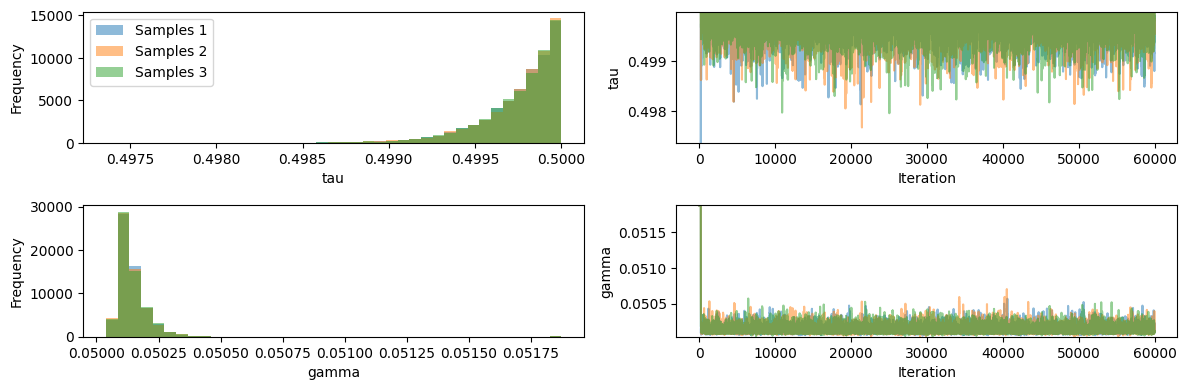

In [72]:
import pints.plot

# Plot histograms of the parameters inferred for South West
param_names=['tau', 'gamma']

pints.plot.trace(warwick_samples, parameter_names=param_names)
plt.show()

In [73]:
# Eliminate burn-in iterations (1/2 of the chain lengths)
warwick_samples = warwick_samples[:, 30000:, :]

# Compute the R-hat estimates for the remaining samples
print(pints.rhat(warwick_samples))

[1.00060674 1.00070562]


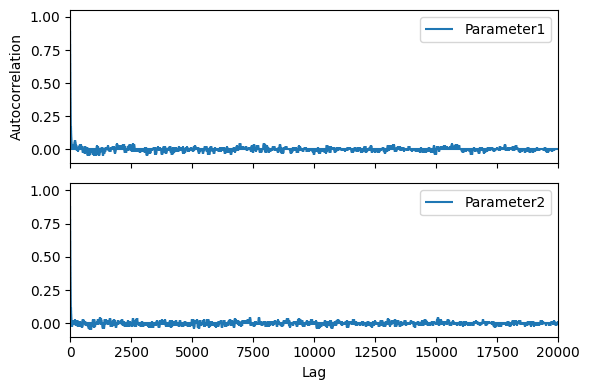

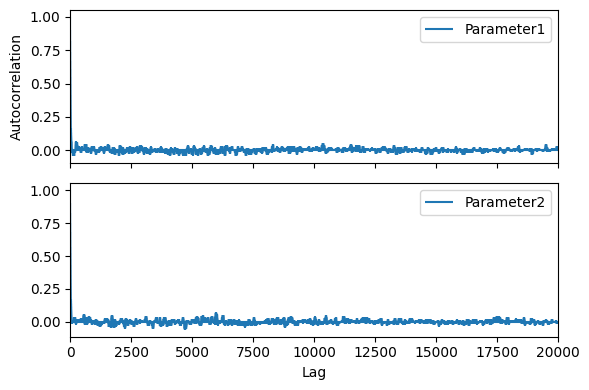

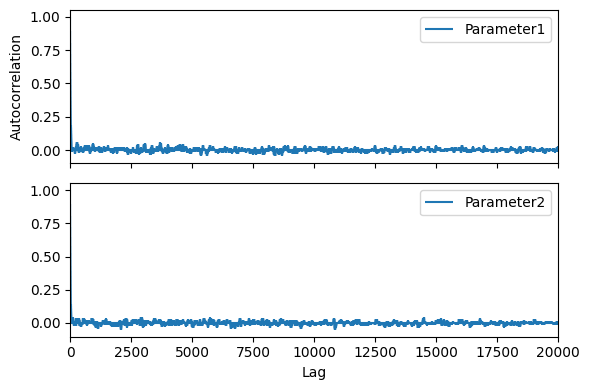

In [74]:
# Plot the autocorrelation for the three chains of parameters for South West
for warwick_sample in warwick_samples:
    pints.plot.autocorrelation(warwick_sample, max_lags=20000)
    plt.show()

### Thin out the MCMC samples (by 10) and run the model with optimised parameter choices to produce predicted timelines for the:
 - number of new infections
 - number of deaths

### Firstly save samples

In [75]:
# Evaluate the model for all parameter sets in the samples
n_chains, n_sample, n_param = warwick_samples.shape

warwick_extended_samples = np.concatenate((warwick_samples[0], warwick_samples[1], warwick_samples[2]), axis=0)

np.savetxt('inference_data/Warwick_Samples.csv', warwick_extended_samples, delimiter=',')

### Warwick Household with fixed contacts

In [26]:
warwick_extended_samples = np.loadtxt('inference_data/Warwick_Samples.csv', delimiter=',')
total_samples = warwick_extended_samples.shape[0]
thinning = max(1, int(total_samples / 9000))

warwick_predicted_new_infec = []
warwick_predicted_deaths = []
warwick_predicted_reprod_num = []

# Run model and number of new infections for all regions
for r, _ in enumerate(regions):
    warwick_reg_predicted_new_infec = []
    warwick_reg_predicted_deaths = []
    warwick_reg_predicted_reprod_num = []

    warwick_model_parameters.simulation_parameters.region_index = r + 1

    for params in warwick_extended_samples[::thinning, :]:
        warwick_model_parameters.disease_parameters.tau = params[0]
        warwick_model_parameters.transmission_parameters.gamma = params[1]
        
        warwick_r = np.empty(len(times))
        warwick_model_reg_deaths_data = np.empty(len(times))

        # Run model and number of new infections for all age groups
        warwick_model_output = warwick_model.simulate(warwick_model_parameters)

        warwick_age_model_reg_new_infections = warwick_model.new_infections(warwick_model_output)
        warwick_model_reg_new_infections = warwick_age_model_reg_new_infections.sum(axis=1)

        warwick_age_model_reg_new_hosp = warwick_model.new_hospitalisations(warwick_age_model_reg_new_infections, pDtoH, dDtoH)
        warwick_model_reg_new_hosp = warwick_age_model_reg_new_hosp.sum(axis=1)

        warwick_age_model_reg_new_deaths = warwick_model.new_deaths(warwick_age_model_reg_new_hosp, pHtoDeath, dHtoDeath)

        warwick_model.compute_transition_matrix()
        for t, time in enumerate(times):
            warwick_r[t] = warwick_model.compute_rt_trajectory(warwick_model_output, t)
            warwick_model_reg_deaths_data[t] = np.sum(warwick_model.mean_deaths(t, warwick_age_model_reg_new_deaths))
        
        warwick_reg_predicted_new_infec.append(warwick_model_reg_new_infections)
        warwick_reg_predicted_deaths.append(warwick_model_reg_deaths_data)
        warwick_reg_predicted_reprod_num.append(warwick_r)

    warwick_reg_predicted_new_infec = np.array(warwick_reg_predicted_new_infec)

    warwick_predicted_new_infec.append(warwick_reg_predicted_new_infec)
    warwick_predicted_deaths.append(warwick_reg_predicted_deaths)
    warwick_predicted_reprod_num.append(warwick_reg_predicted_reprod_num)

warwick_predicted_new_infec = np.array(warwick_predicted_new_infec)
warwick_predicted_deaths = np.array(warwick_predicted_deaths)
warwick_predicted_reprod_num = np.array(warwick_predicted_reprod_num)


### Compute mean and CI bounds of the trajectories of interest and select predicted quantities to plot

### Warwick Household with fixed contacts

In [27]:
# Set up traces to plot
warwick_new_infec_mean = []
warwick_deaths_mean = []
warwick_reprod_num_mean = []

warwick_new_infec_upper = []
warwick_deaths_upper = []
warwick_reprod_num_upper = []

warwick_new_infec_lower = []
warwick_deaths_lower = []
warwick_reprod_num_lower = []

for r, _ in enumerate(regions):
    # Compute the mean 
    warwick_new_infec_mean.append(np.mean(warwick_predicted_new_infec[r,:,:], axis=0))
    warwick_deaths_mean.append(np.mean(warwick_predicted_deaths[r,:,:], axis=0))
    warwick_reprod_num_mean.append(np.mean(warwick_predicted_reprod_num[r,:,:], axis=0))

    # Compute the upper quantiles
    warwick_new_infec_upper.append(np.quantile(warwick_predicted_new_infec[r,:,:], 0.975, axis=0))
    warwick_deaths_upper.append(np.quantile(warwick_predicted_deaths[r,:,:], 0.975, axis=0))
    warwick_reprod_num_upper.append(np.quantile(warwick_predicted_reprod_num[r,:,:], 0.975, axis=0))

    # Compute the lower qunatiles
    warwick_new_infec_lower.append(np.quantile(warwick_predicted_new_infec[r,:,:], 0.025, axis=0))
    warwick_deaths_lower.append(np.quantile(warwick_predicted_deaths[r,:,:], 0.025, axis=0))
    warwick_reprod_num_lower.append(np.quantile(warwick_predicted_reprod_num[r,:,:], 0.025, axis=0))

In [29]:
# Trace names - represent the solver used for the simulation
trace_name = ['Synthetic']
titles = ['Infections', 'Deaths', 'Reproduction Number']

fig = go.Figure()
fig = make_subplots(rows=len(titles), cols=1, subplot_titles=tuple(titles), horizontal_spacing = 0.15)

# Plot (continuous predicted timeline and pointwise observed numbers each day)
for r, region in enumerate(regions):
    # Plot of infections
    fig.add_trace(
        go.Scatter(
            x=times,
            y=warwick_new_infec_mean[r].tolist(),
            mode='lines',
            name=trace_name[r],
            line_color=colours[r]
        ),
        row= 1,
        col= 1
    )

    fig.add_trace(
        go.Scatter(
            x=times + times[::-1],
            y=warwick_new_infec_upper[r].tolist() + warwick_new_infec_lower[r].tolist()[::-1],
            fill='toself',
            fillcolor=colours[r],
            line_color=colours[r],
            opacity=0.3,
            mode='lines',
            showlegend=False,
            name=trace_name[r]
        ),
        row= 1,
        col= 1
    )

    fig.add_trace(
        go.Scatter(
            x=times,
            y=np.sum(cases_data[r], axis=1).tolist(),
            mode='markers',
            name=trace_name[r],
            showlegend=False,
            line_color=colours[r]
        ),
        row= 1,
        col= 1
    )

    # Plot deaths
    fig.add_trace(
        go.Scatter(
            x=times,
            y=warwick_deaths_mean[r].tolist(),
            mode='lines',
            name=trace_name[r],
            showlegend=False,
            line_color=colours[r]
        ),
        row= 2,
        col= 1
    )

    fig.add_trace(
        go.Scatter(
            x=times + times[::-1],
            y=warwick_deaths_upper[r].tolist() + warwick_deaths_lower[r].tolist()[::-1],
            fill='toself',
            fillcolor=colours[r],
            line_color=colours[r],
            opacity=0.3,
            mode='lines',
            showlegend=False,
            name=trace_name[r]
        ),
        row= 2,
        col= 1
    )

    fig.add_trace(
        go.Scatter(
            x=times,
            y=np.sum(deaths_data[r], axis=1).tolist(),
            mode='markers',
            name=trace_name[r],
            showlegend=False,
            line_color=colours[r]
        ),
        row= 2,
        col= 1
    )

    # Plot reproduction number
    fig.add_trace(
        go.Scatter(
            x=times,
            y=warwick_reprod_num_mean[r].tolist(),
            mode='lines',
            name=trace_name[r],
            showlegend=False,
            line_color=colours[r]
        ),
        row= 3,
        col= 1
    )

    fig.add_trace(
        go.Scatter(
            x=times + times[::-1],
            y=warwick_reprod_num_upper[r].tolist() + warwick_reprod_num_lower[r].tolist()[::-1],
            fill='toself',
            fillcolor=colours[r],
            line_color=colours[r],
            opacity=0.3,
            mode='lines',
            showlegend=False,
            name=trace_name[r]
        ),
        row= 3,
        col= 1
    )

# Add axis labels
fig.update_layout(
    width=600, 
    height=900,
    plot_bgcolor='white',
    xaxis=dict(
        linecolor='black',
        tickvals=np.arange(1, 90, 10).tolist(),
        ticktext=['Feb 15', 'Feb 25', 'Mar 06', 'Mar 16', 'Mar 26', 'Apr 05', 'Apr 15', 'Apr 25', 'May 05', 'May 15']),
    yaxis=dict(linecolor='black'),
    xaxis2=dict(
        linecolor='black',
        tickvals=np.arange(1, 90, 10).tolist(),
        ticktext=['Feb 15', 'Feb 25', 'Mar 06', 'Mar 16', 'Mar 26', 'Apr 05', 'Apr 15', 'Apr 25', 'May 05', 'May 15']),
    yaxis2=dict(linecolor='black'),
    xaxis3=dict(
        linecolor='black',
        tickvals=np.arange(1, 90, 10).tolist(),
        ticktext=['Feb 15', 'Feb 25', 'Mar 06', 'Mar 16', 'Mar 26', 'Apr 05', 'Apr 15', 'Apr 25', 'May 05', 'May 15']),
    yaxis3=dict(linecolor='black'),
    legend=dict(
        orientation='h',
        yanchor="bottom",
        y=1.075,
        xanchor="right",
        x=1)
    )

fig.write_image('images/Figure-Warwick-Luxembourg.pdf')
fig.show()